# Analyse GNSS derived vertical ground motion
also setting into context with dv/v as in Makus et al., 2024

In [1]:
proj_dir = '/path/to/your/project'

In [2]:
import os
import glob
import pandas as pd
import datetime
import numpy as np

from obspy import UTCDateTime
from pytz import UTC


infiles = glob.glob('gnss_cleaned/USGS/*U.data')
coord_file = 'gnss_cleaned/coords.txt'
df_coords = pd.read_csv(
    coord_file, delim_whitespace=True, skipinitialspace=True, names=('station', 'lat', 'lon', 'elevation'))

positions = {}


for infile in infiles:
    # retrieve station name
    station = os.path.basename(infile).split('.')[0].split('_')[0].upper()
    # retrieve GPS position and time dependent height
    # create new date column
    df = pd.read_csv(
        infile, delim_whitespace=True,
        skipinitialspace=True, usecols=(1, 2, 3, 4),
        names=('offset', 'std', 'year', 'doy'))
    
    # convert year and doy to date
    df['t'] = [UTCDateTime(
        year=int(y), julday=int(jd)) for y, jd in zip(df['year'], df['doy'])]
    # compute velocity m/day
    df['velocity'] = df['offset'].diff() / (df['t'].diff()*24*3600)
    df['velocity'] = df['velocity'].rolling(365, center=True).mean()
    df['datetime'] = [x.datetime for x in df['t']]
    # Remove last 15 rows
    # smooth offset
    df['offset'] = df['offset'].rolling(60, center=True).mean()
    df['offset'] /= 1000 # convert to meters
    df = df[:-30]
    try:
        df['lat'] = df_coords['lat'][df_coords['station'] == station].values[0]
        df['lon'] = df_coords['lon'][df_coords['station'] == station].values[0]
        df['elevation'] = df_coords['elevation'][df_coords['station'] == station].values[0]
    except IndexError:
        print(station, ' no coords found')
        continue
    # set offset to zero where t is closest to 2007-01-01
    if min(abs(df['t'] - UTCDateTime(2007, 7, 1))) > 30*3600:
        print(station, ' is not available')
        continue
    argmin = np.argmin(abs(df['t'] - UTCDateTime(2007, 7, 1)))
    df['offset'] = df['offset'] - df['offset'][argmin]
    positions[station] = df

TSEP  is not available
SEPR  is not available


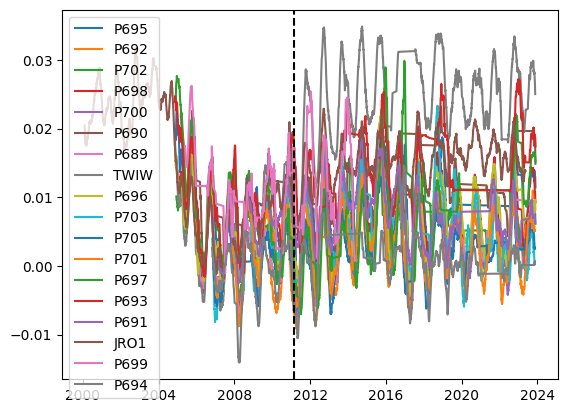

In [3]:
# plot all together as test
# plot this on a cartesian grid
import matplotlib.pyplot as plt
import numpy as np

# first simply in 1D
for station, df in positions.items():
    if station in ('TWRI', 'TGUA', 'THAR', 'TSTU'):
        continue
    plt.plot(df['datetime'], positions[station]['offset'], label=station)
# make a vertical line on 2011-02-15
plt.axvline(datetime.datetime(2011, 2, 15), color='k', linestyle='--')
plt.legend()


In [28]:
# load dv time-series
import glob
import os

import numpy as np
from matplotlib import pyplot as plt
from obspy import UTCDateTime


corr_len = 2
std_model = 0.004
dv = {}
for freq0 in [0.25, 0.5, 1.0]:
    infile = glob.glob(os.path.join(
        proj_dir,
        f'spatial_{corr_len}_std{std_model}/{freq0}*/dvdt_3D.npz')[0]

    loaded = np.load(infile)

    x = loaded['xaxis']
    y = loaded['yaxis']
    t = loaded['taxis']
    dvdt = loaded['dv']

    start = np.argmin(abs(t - UTCDateTime('2007-06-01').timestamp))
    t = t[start:]
    dv[freq0] = -100*dvdt[:, :, start:]
datetimes = [UTCDateTime(tt).datetime for tt in t]


## 1D comparison dv/v and GPS motion

/tmp/ipykernel_10611/3985598591.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


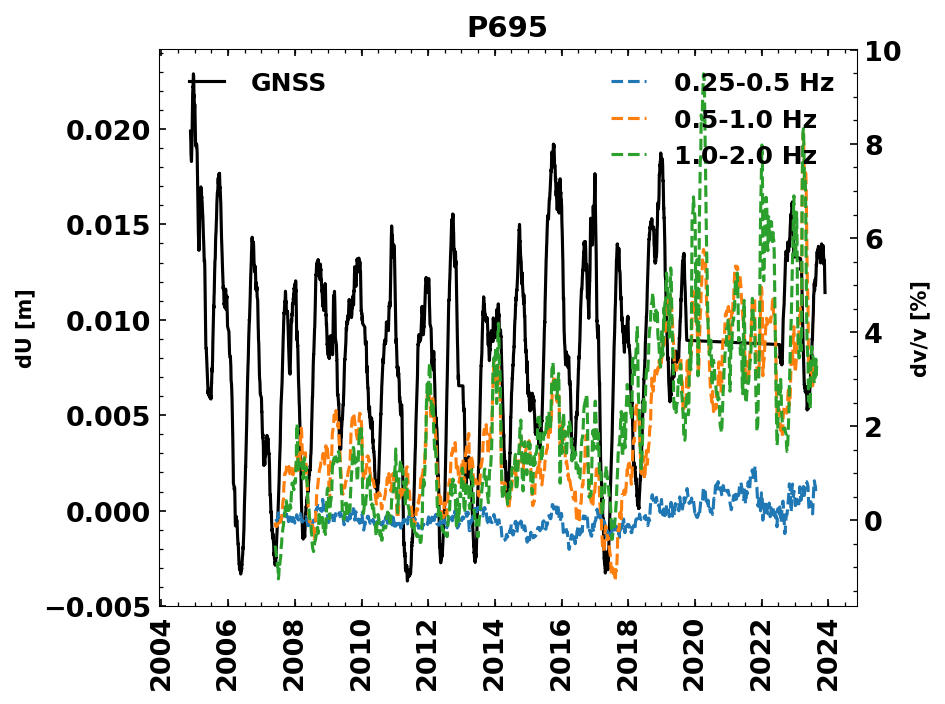

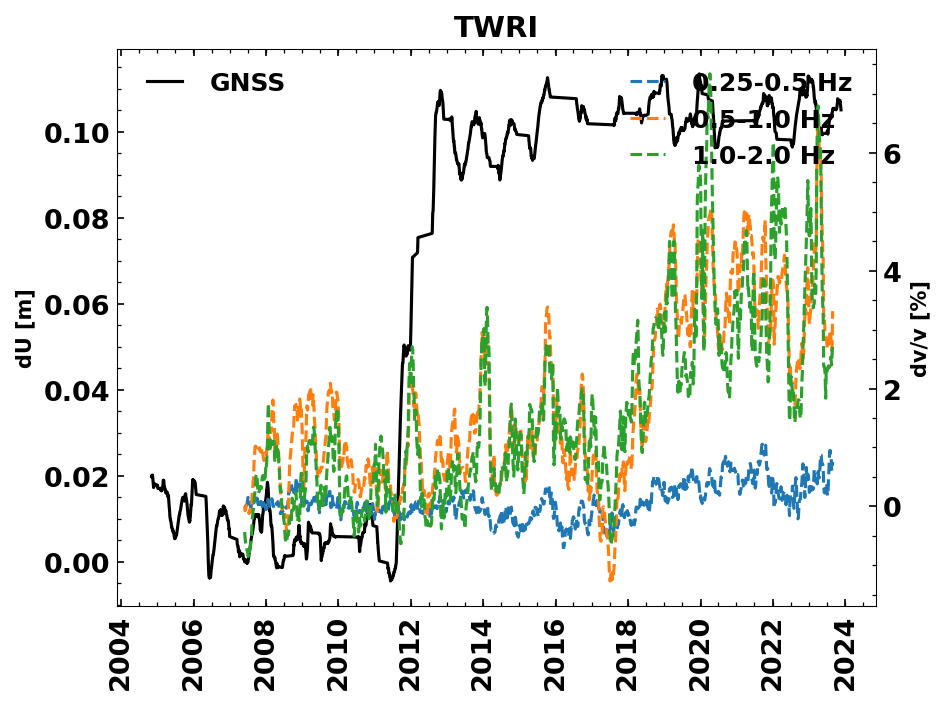

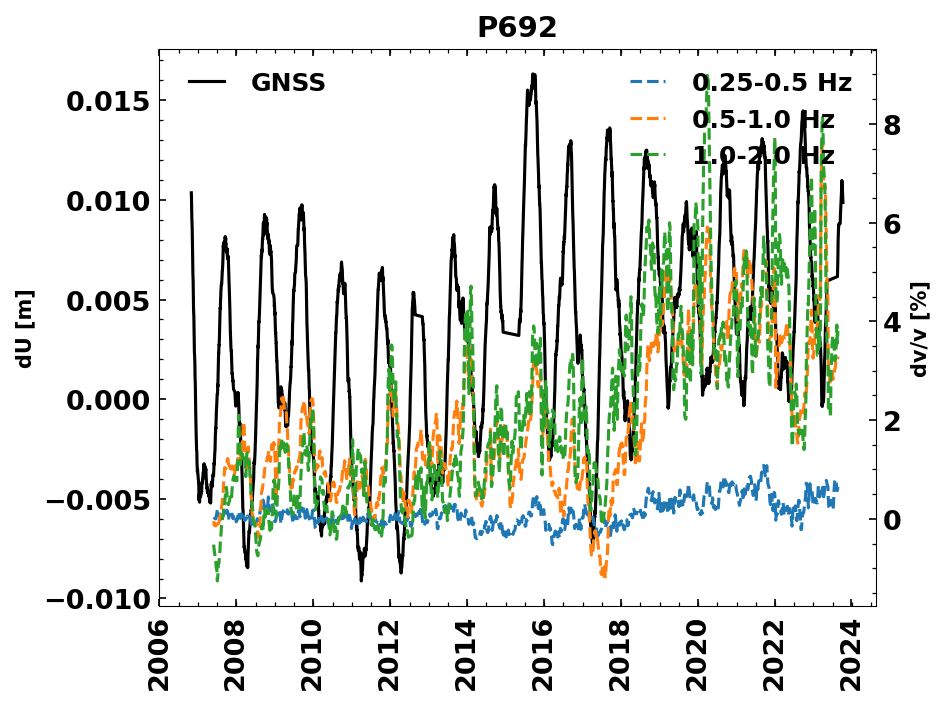

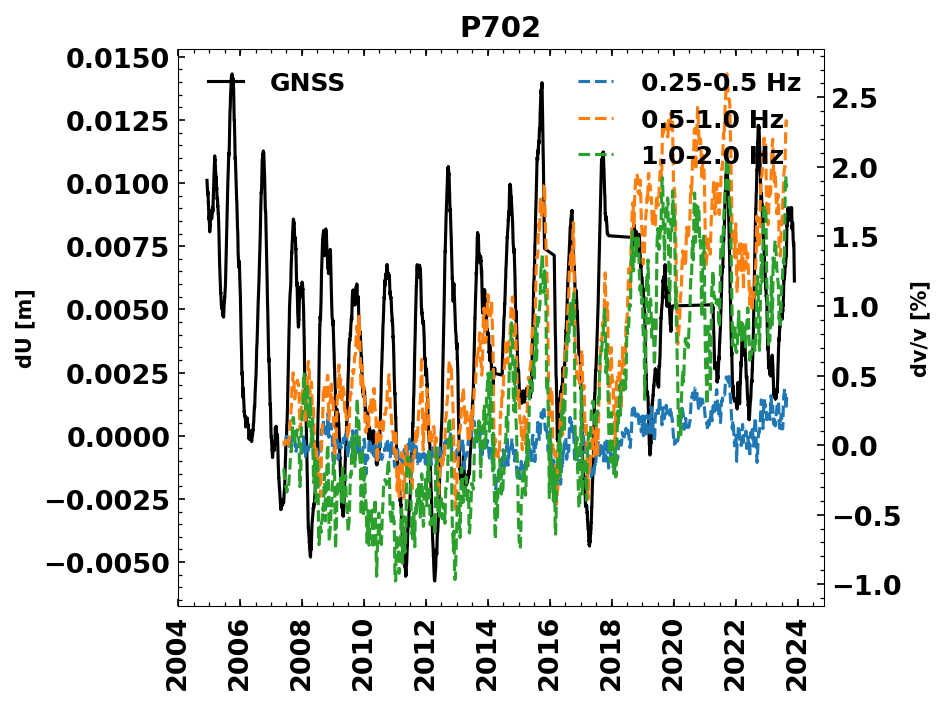

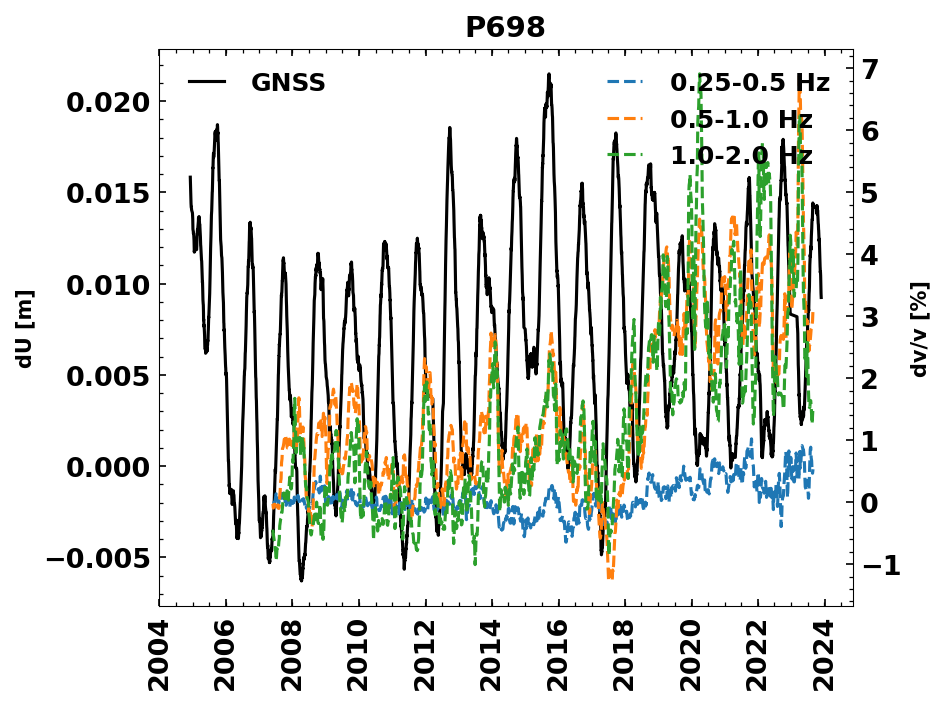

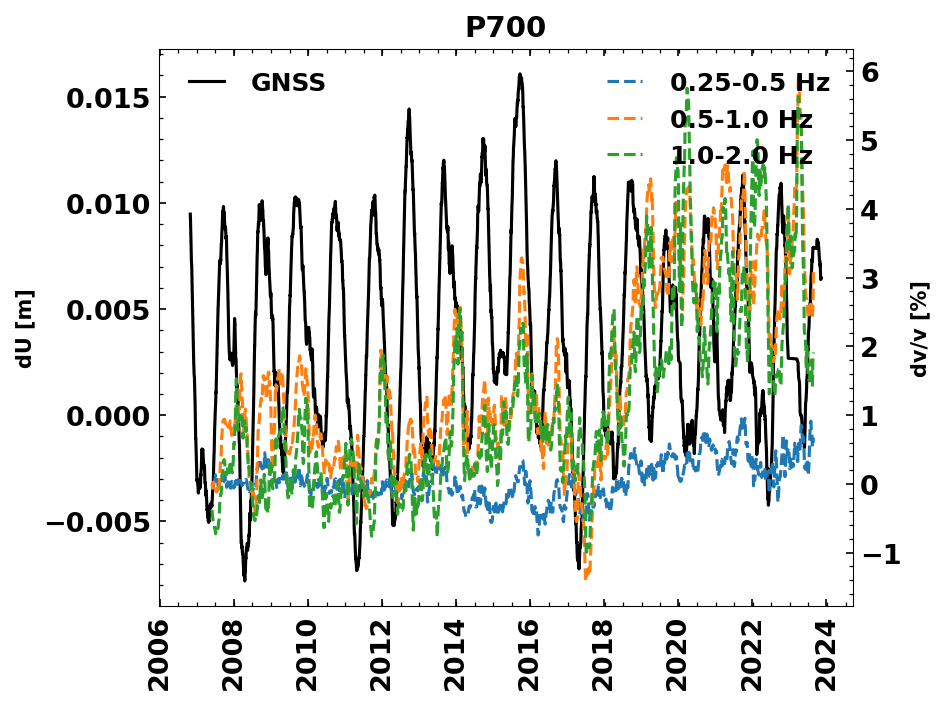

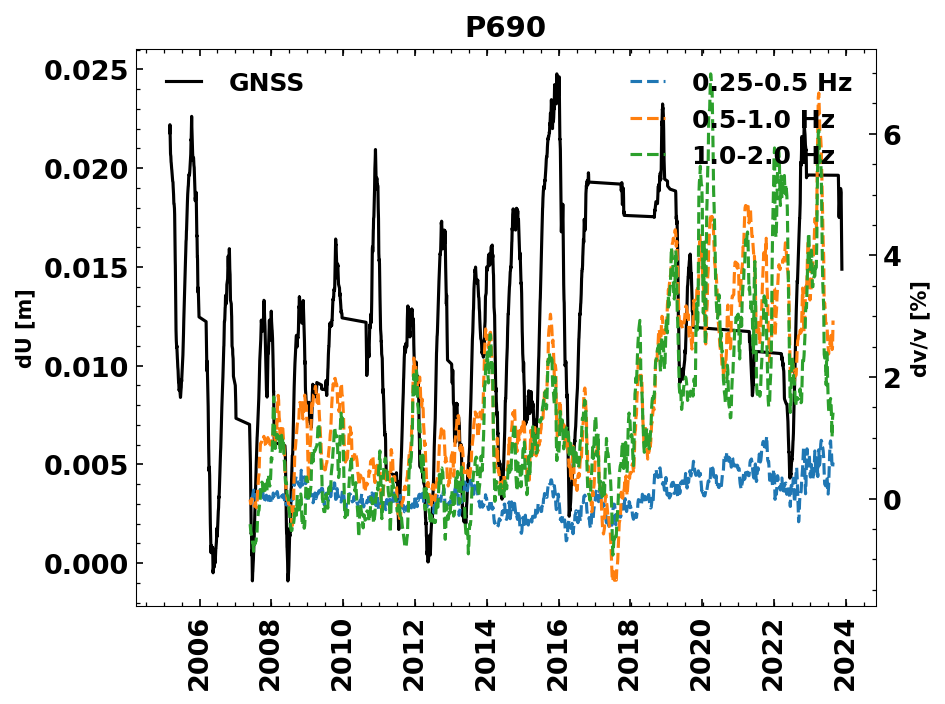

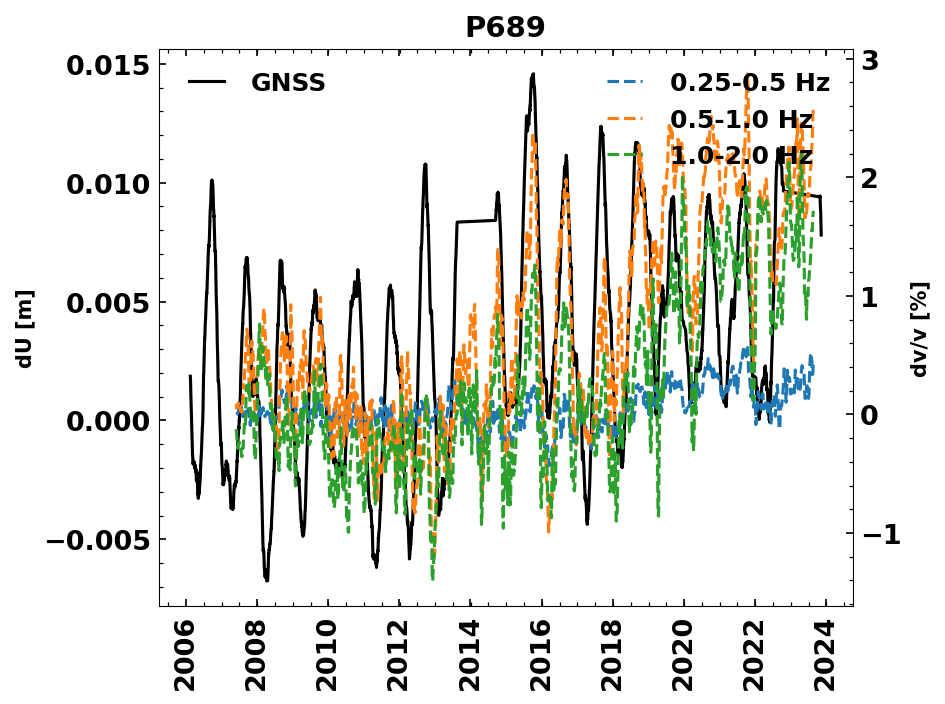

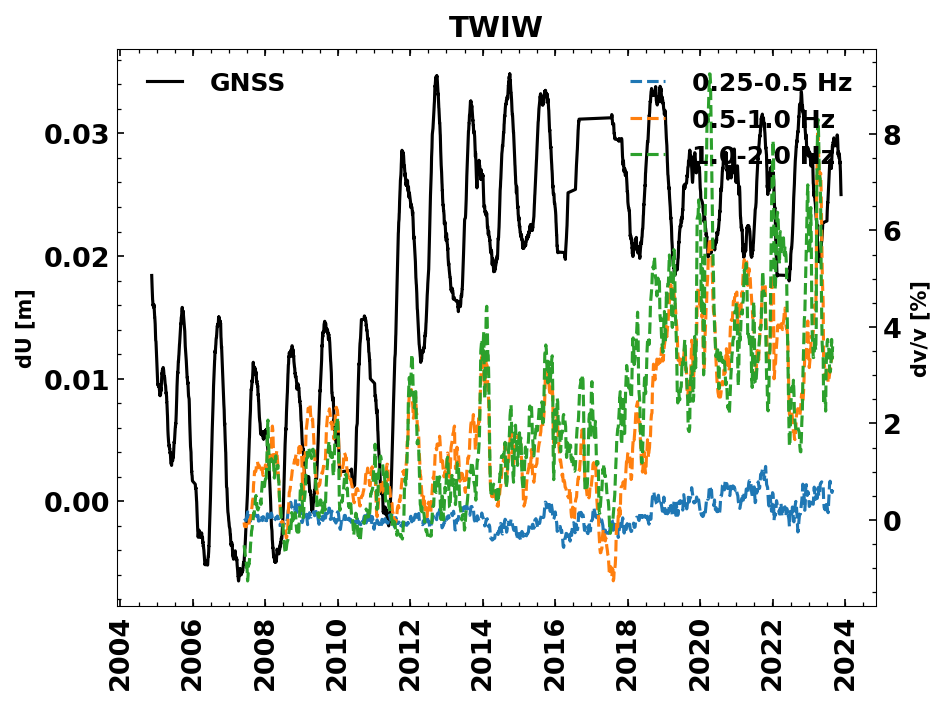

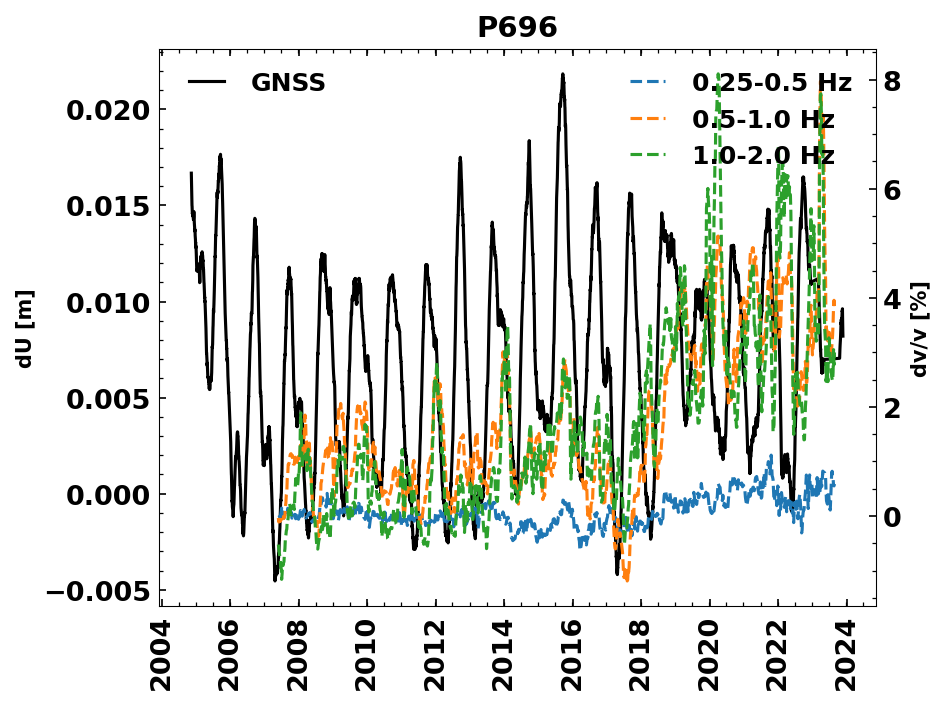

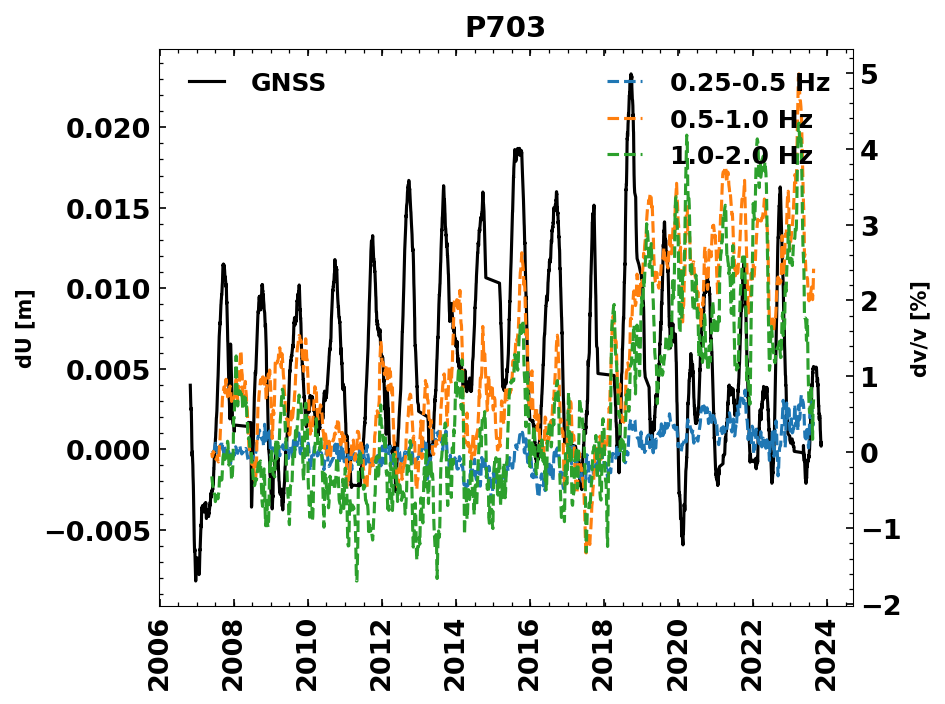

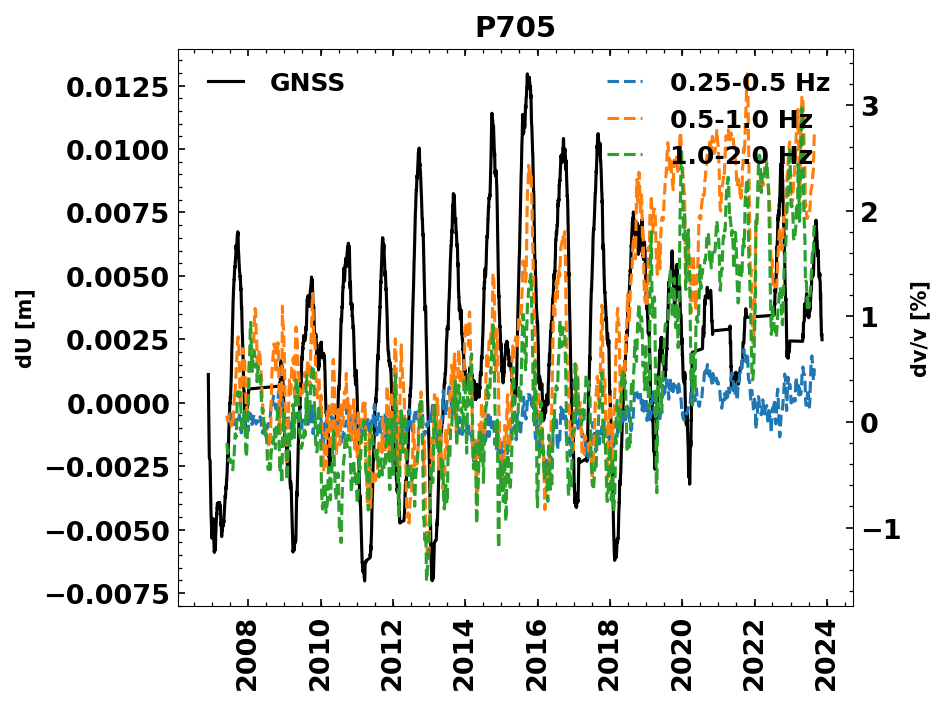

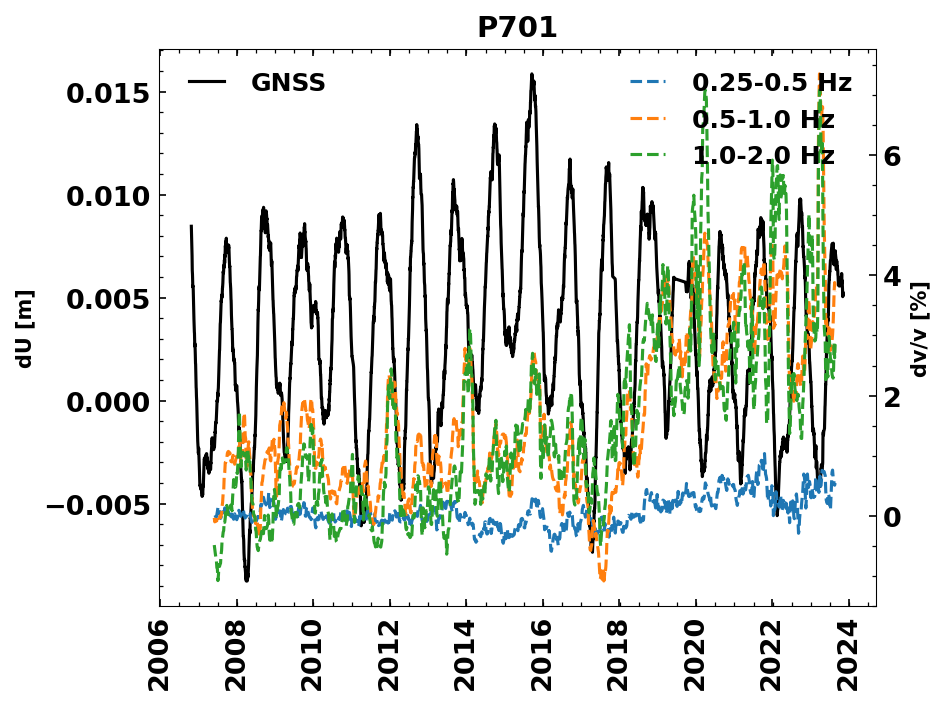

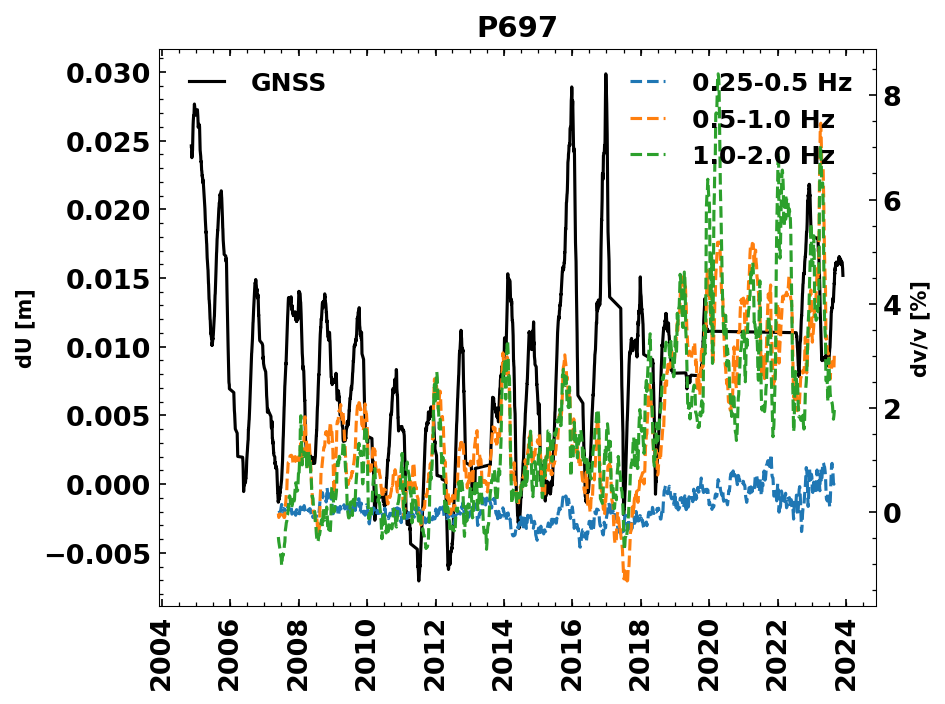

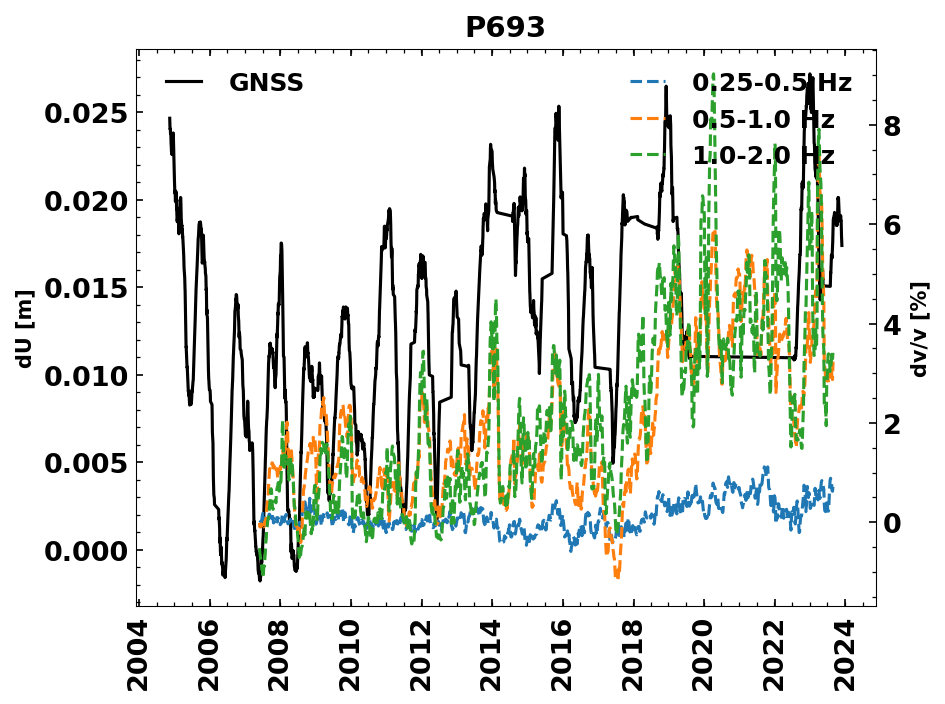

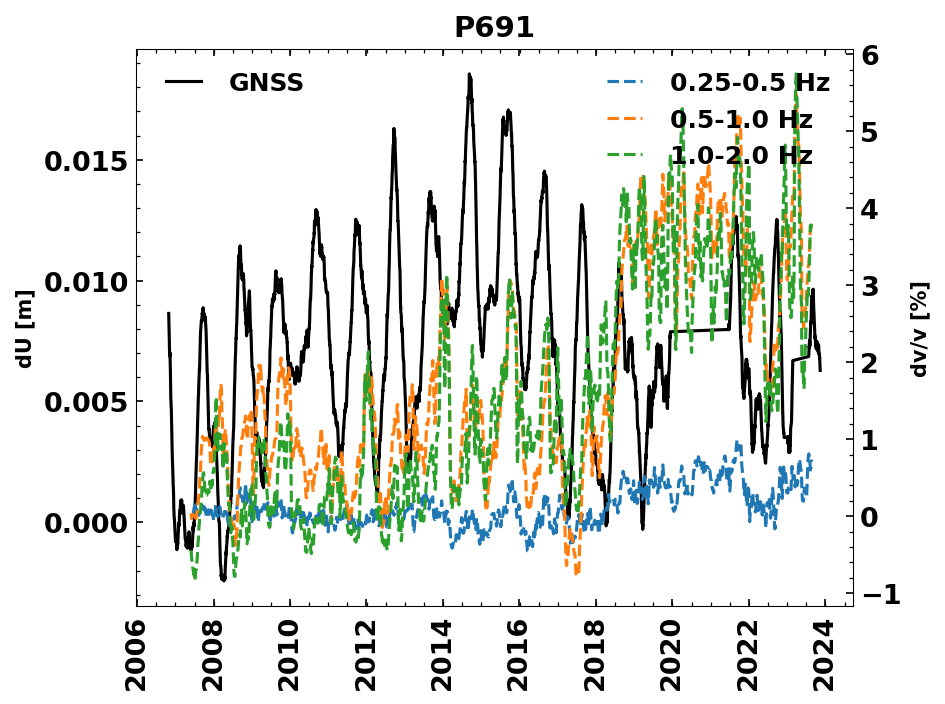

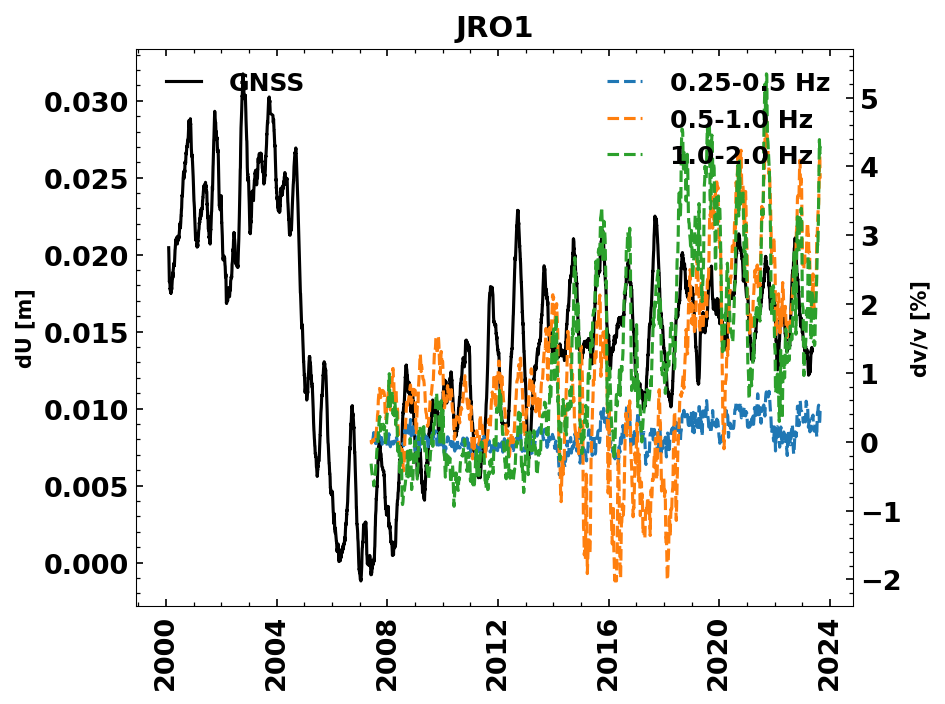

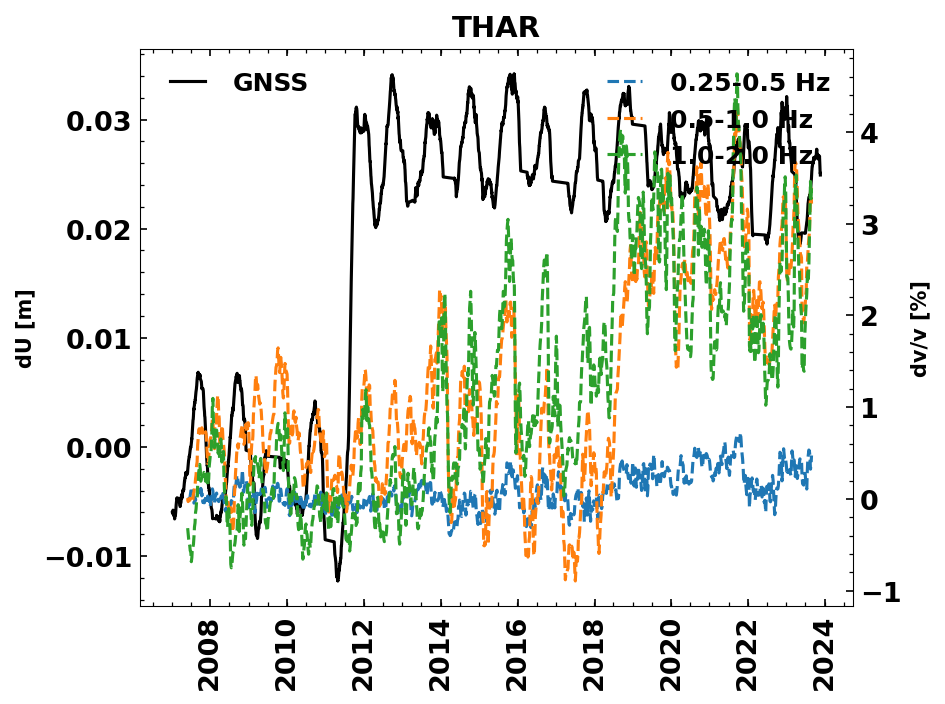

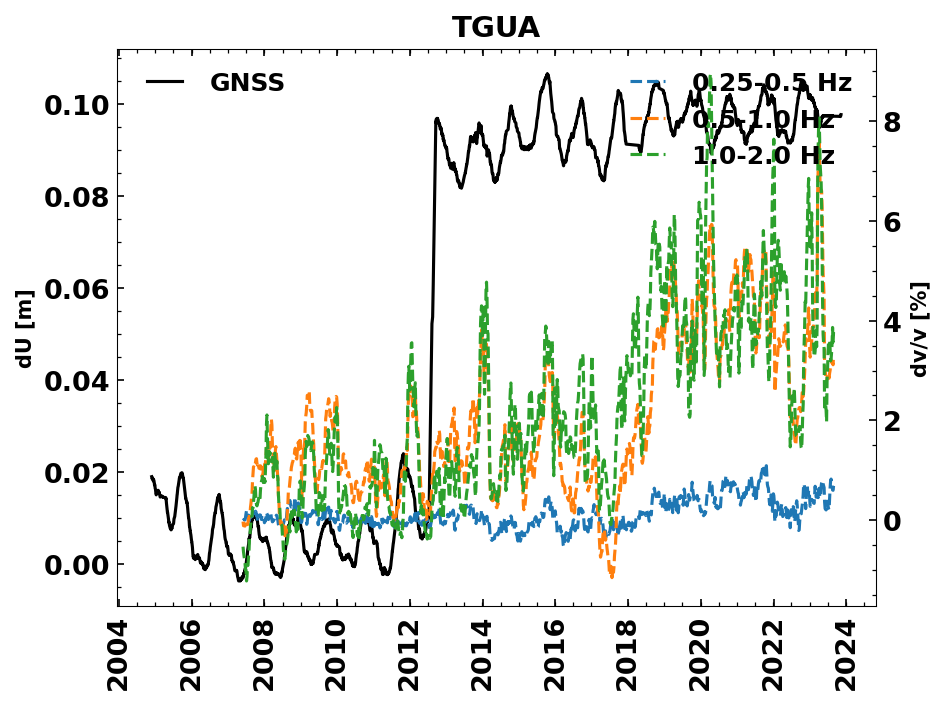

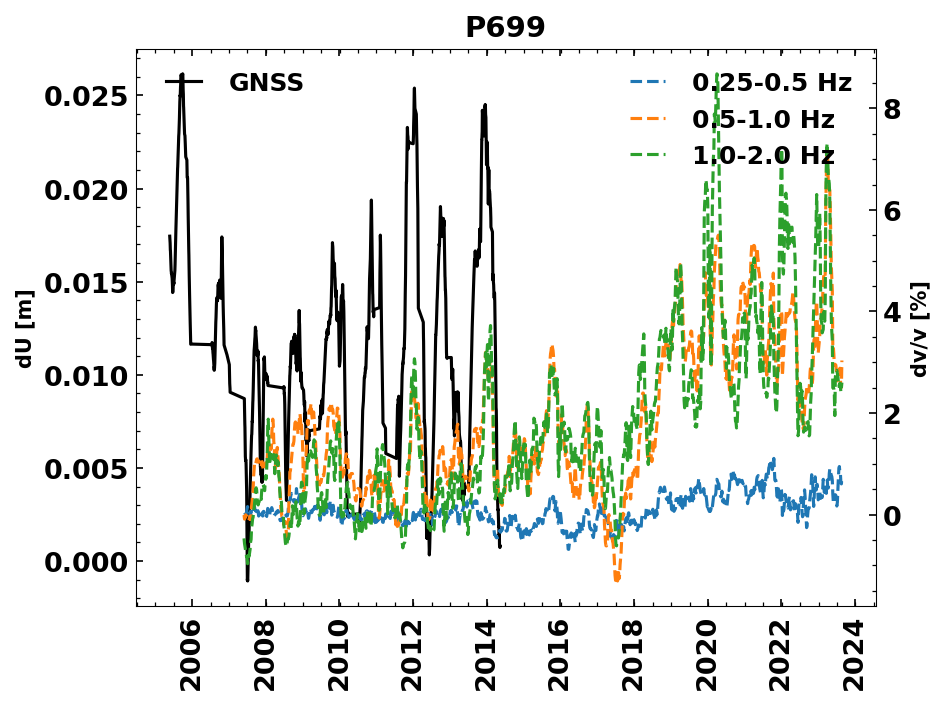

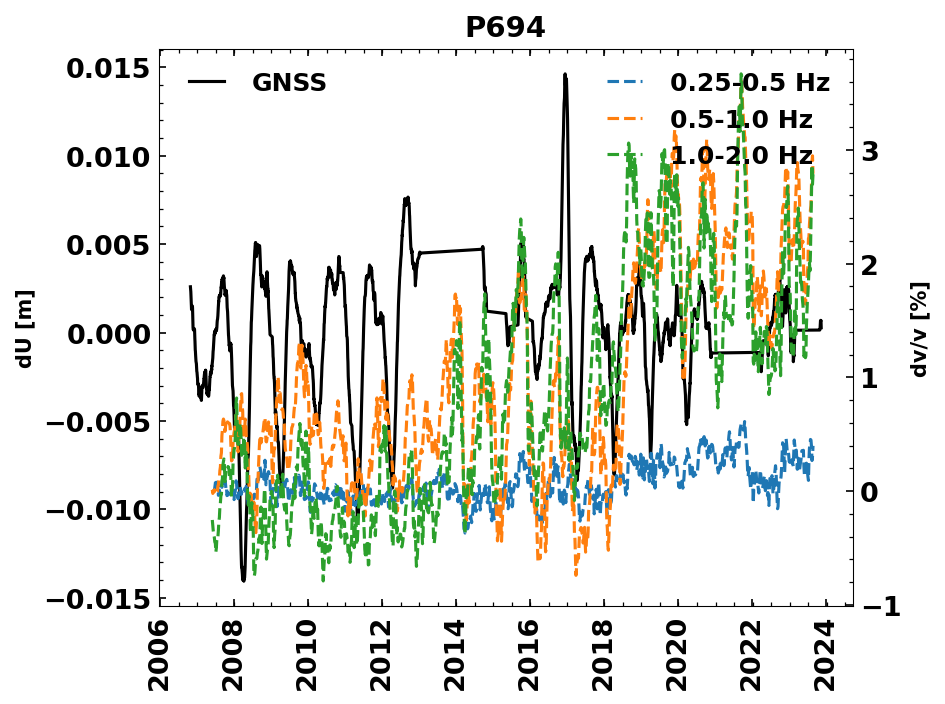

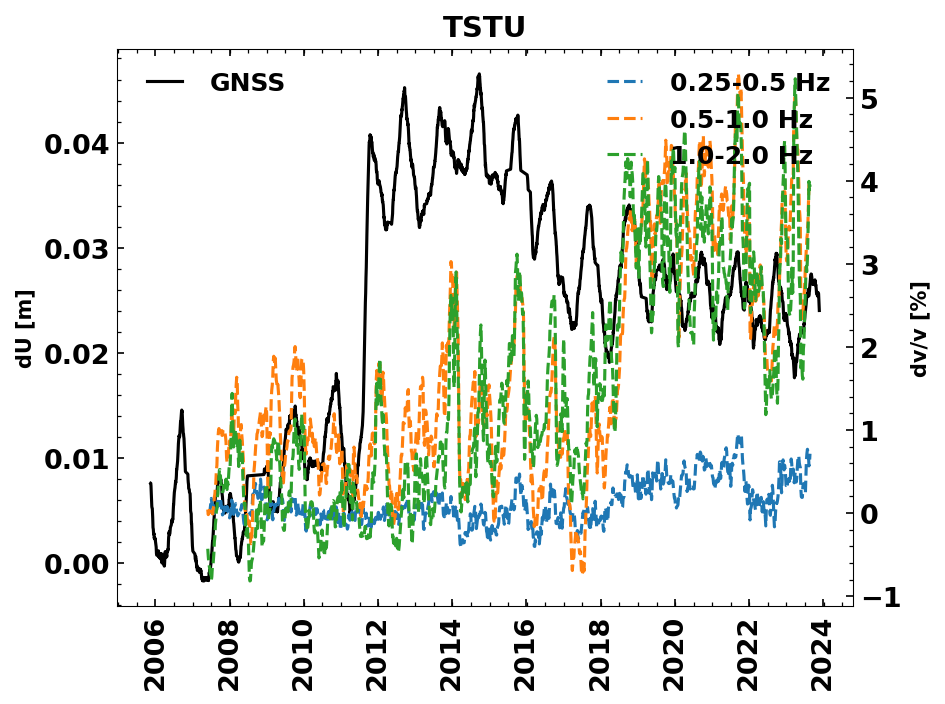

In [32]:
from seismic.plot.plot_utils import set_mpl_params

set_mpl_params()

# find closest grid point of each station and plot against dv/v of this grid point

for station, df in positions.items():
    plt.figure()
    # find closest grid point
    plt.plot(df['datetime'], df['offset'], label='GNSS', color='k')
    plt.ylabel('dU [m]')
    plt.legend()
    # rotate xticklabels by 90 deg
    plt.xticks(rotation=90)
    plt.twinx()
    xind = np.argmin(np.abs(df['x'][0] - x))
    yind = np.argmin(np.abs(df['y'][0] - y))
    # plot dv/v time series
    for freq0 in [0.25, 0.5, 1.0]:
        plt.plot(datetimes, dv[freq0][yind, xind, :], label=f'{freq0}-{freq0*2} Hz', linestyle='--')
    # plot this legend in top right
    plt.legend(loc='upper right')
    plt.ylabel('dv/v [%]')
    plt.title(station)
    
    plt.tight_layout()


# UW long time series vs JRO1 GPS

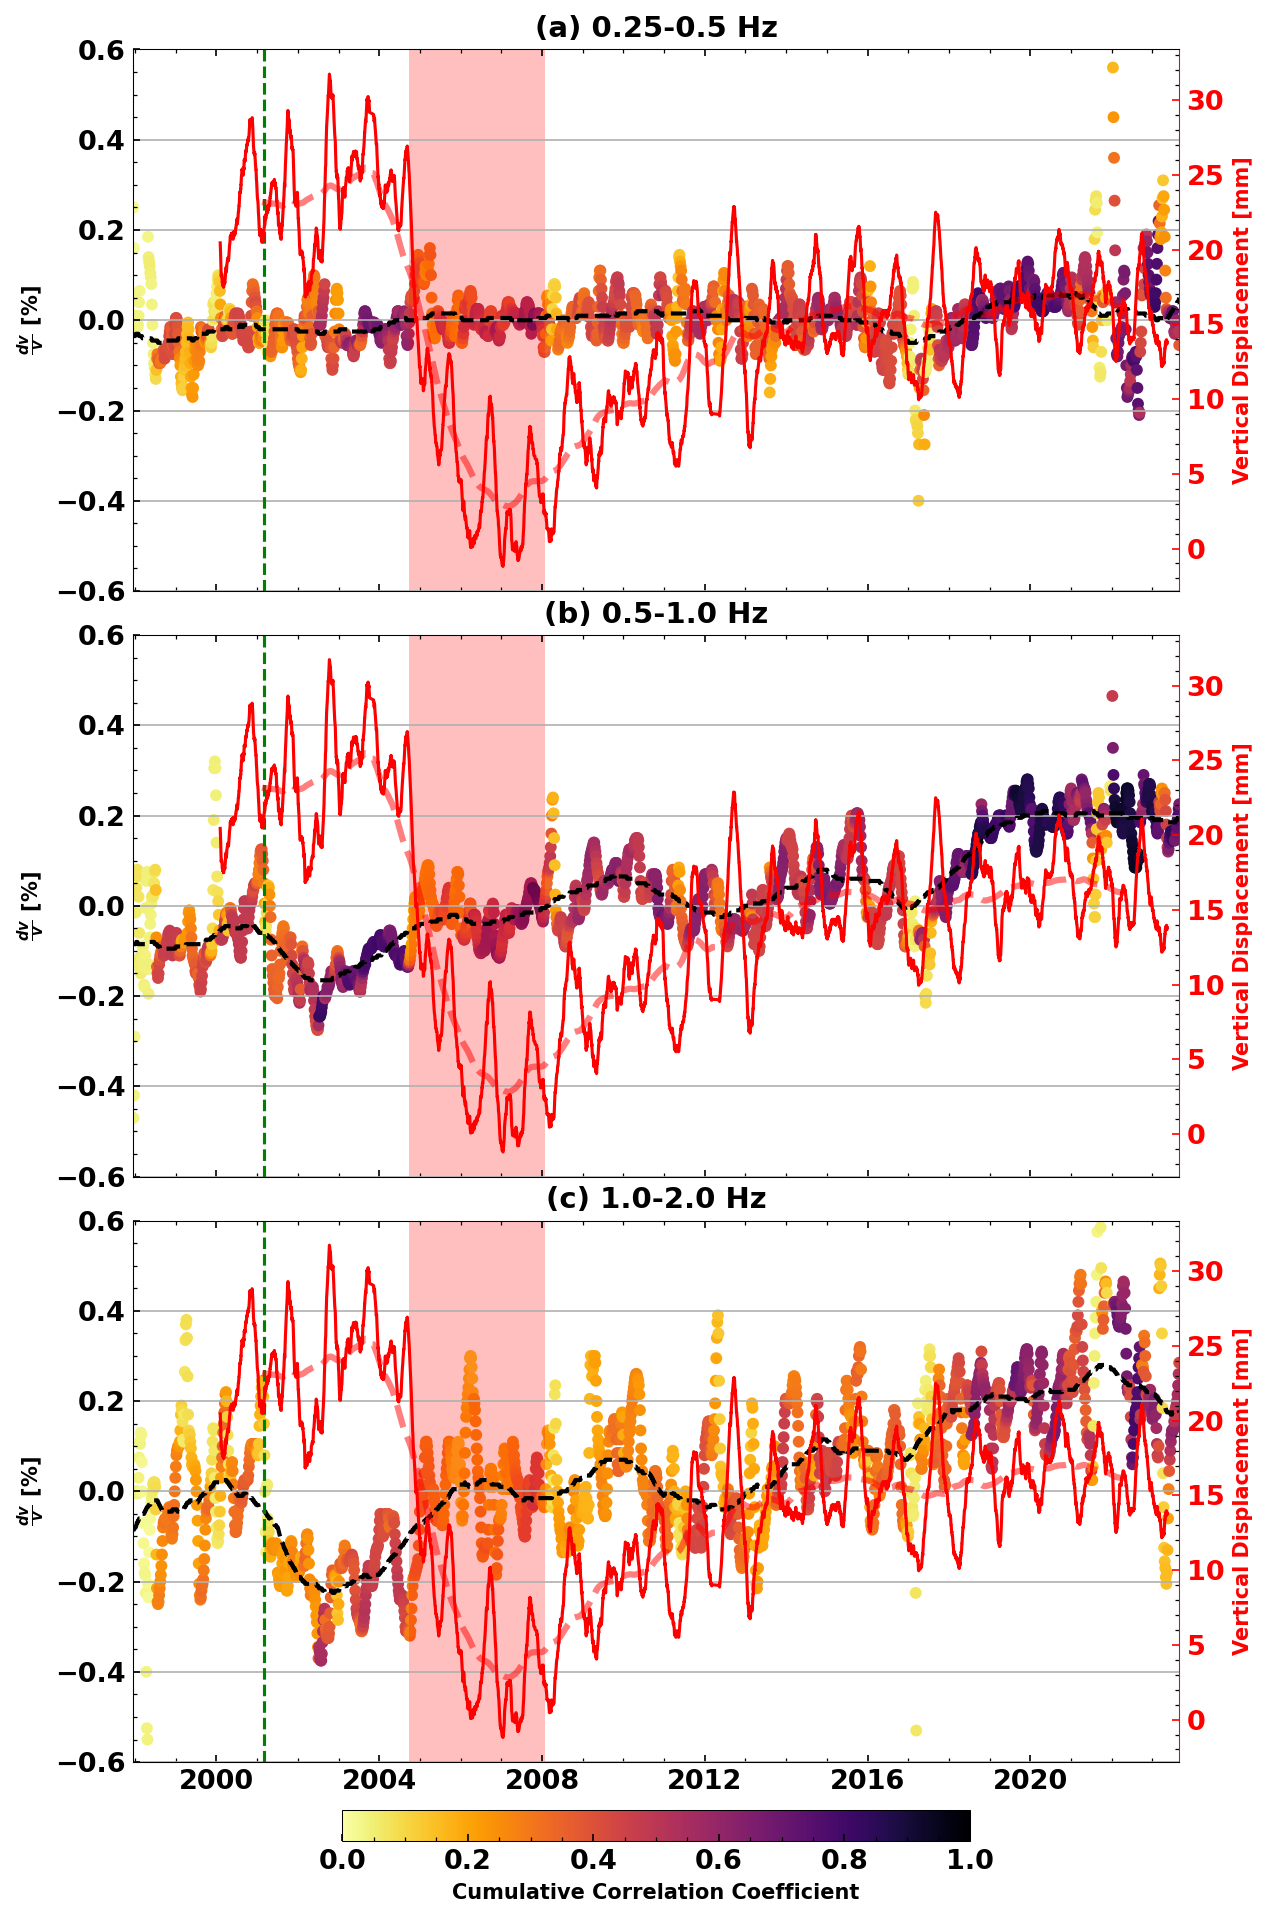

In [33]:
import os
import glob
from copy import deepcopy
from pyrsistent import v

from seismic.monitor.dv import read_dv
from seismic.plot.plot_utils import set_mpl_params

from matplotlib import lines, pyplot as plt
from obspy import UTCDateTime

set_mpl_params()
freqs = [0.25, 0.5, 1.0]
infile = os.path.join(
    proj_dir,
    'dv/with_sim_mat/UW_average_{freq}.npz'
)
outfile = os.path.join(
    proj_dir, 
    'paper/figures/UW_av.pdf')
# plot dv/v time series
dv_avs = {}
for freq in freqs:
    dv_avs[freq] = read_dv(infile.format(freq=freq))

# create subplot for each frequency share x-axis and colorbar
fig, ax = plt.subplots(
    3, 1, sharex=True, figsize=(9, 16),
    gridspec_kw={'height_ratios': [1, 1, 1.25]})

df = positions['JRO1']
# low pass filter the GPS time series
df['offset_smoothed'] = df['offset'].rolling(365*2, center=True).mean()

for i, freq in enumerate(freqs):
    dv_av = dv_avs[freq]
    dv_av_smooth = deepcopy(dv_av)
    # get sample interval
    dt = (dv_av_smooth.stats.corr_start[1] - dv_av_smooth.stats.corr_start[0])/86400
    dv_av_smooth.smooth_sim_mat(int(365*2/dt))

    # plot dv manually instead
    ii = dv_av.avail
    map = ax[i].scatter([t.datetime for t in np.array(dv_av.stats.corr_start)[ii]], -100*dv_av.value[ii], label='raw', c=dv_av.corr[ii], cmap='inferno_r', s=22, vmin=0, vmax=1.0)
    ax[i].plot([t.datetime for t in np.array(dv_av_smooth.stats.corr_start)[ii]], -100*dv_av_smooth.value[ii], 'k--', label='smoothed', linewidth=2)
    # origin time of the Nisqually earthquake
    neq = UTCDateTime('2001-02-28 18:54:32').datetime
    ax[i].vlines(neq, -.6, .6, colors=['g'], linestyles='dashed')
    ax[i].axvspan(UTCDateTime(2004, 9, 23).datetime, UTCDateTime(2008, 1, 31).datetime, facecolor='r', alpha=0.25)
    ax[i].set_ylabel(r'$\frac{dv}{v}$ [%]')
    ax[i].set_xlabel('')
    ax[i].set_ylim(-.6, .6)
    # make vertical grid
    ax[i].grid(axis='y')
    if i == 0:
        title = '(a) 0.25-0.5 Hz'
    elif i == 1:
        title = '(b) 0.5-1.0 Hz'
    else:
        title = '(c) 1.0-2.0 Hz'
    ax[i].set_title(title)
    ax[i].set_xlim(np.array(dv_av_smooth.stats.corr_start)[ii][0].datetime, np.array(dv_av_smooth.stats.corr_start)[ii][-1].datetime)
    ax2 = ax[i].twinx()
    # plot GPS time series
    df = positions['JRO1']
    ax2.plot(df['datetime'], df['offset']*1e3, label='GNSS', color='r')
    ax2.plot(
        df['datetime'], df['offset_smoothed']*1e3, label='GNSS', color='r',
        linestyle='--', linewidth=3, alpha=.5)
    ax2.set_ylabel('Vertical Displacement [mm]', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.spines['right'].set_color('r')
    ax2.tick_params(axis='y', colors='r')

plt.subplots_adjust(hspace=0.075)

fig.colorbar(
    map, orientation='horizontal', pad=0.05, shrink=.6,
    label='Cumulative Correlation Coefficient', anchor=(0.5, .8))


## Plotting GPS against dv/v - comparison of seasonal signals

/tmp/ipykernel_19667/798244582.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat['offset_hpf'][nani] += np.nan
/tmp/ipykernel_19667/798244582.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat['offset_hpf'][nani] += np.nan
/tmp/ipykernel_19667/798244582.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat['offset_hpf'][nani] += np.nan
/tmp/ipykernel_19667/798244582.py:12: SettingWithCopyWarning: 
A value is trying t

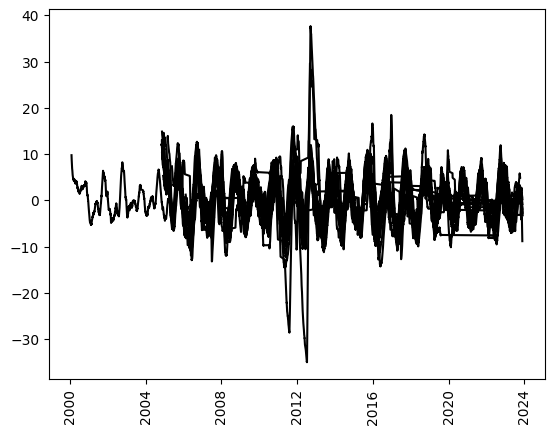

In [4]:
# highpass filter GPS time series
from obspy.signal.filter import highpass
from scipy.signal import detrend
for stat in positions.values():
    # plt.figure()
    nani = np.isnan(stat['offset'])
    offset_1d = np.nan_to_num(stat['offset'], copy=True)
    df = 1/(stat['datetime'][1]-stat['datetime'][0]).total_seconds()
    filtfreq = 1/(365.25*24*60*60*2)
    # mask nans
    stat['offset_hpf'] = highpass(offset_1d, filtfreq, df, corners=4, zerophase=True)
    stat['offset_hpf'][nani] += np.nan
    stat['offset_hpf'] -= np.nanmean(stat['offset_hpf'])
    plt.plot(stat['datetime'], stat['offset_hpf']*1e3, 'k', zorder=0)
    # rotate xticklabels by 90 deg
    plt.xticks(rotation=90)
    

### Do this but for station combinations

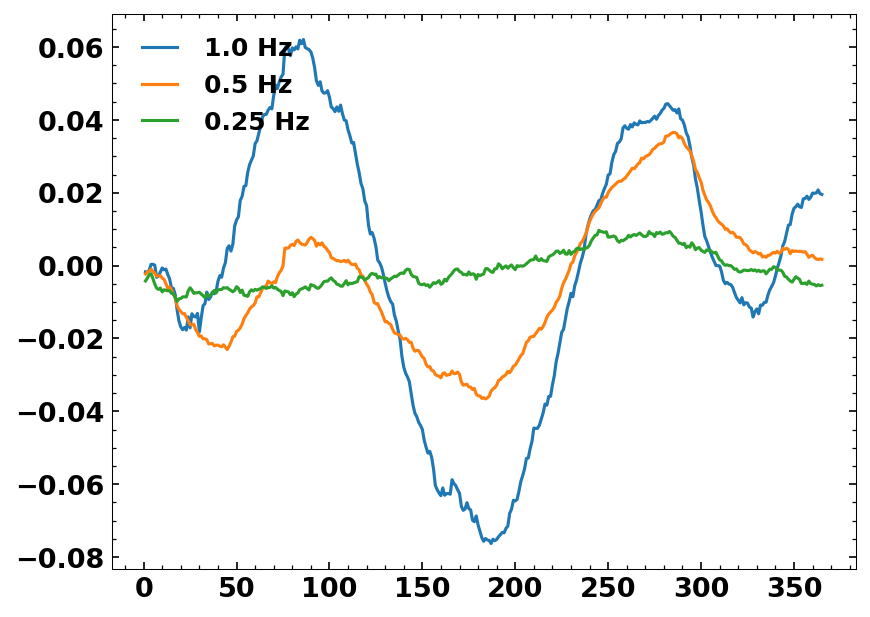

In [38]:
# open values computed on cascadia
import numpy as np
dv_median_single = {}
for freq0 in (0.25, 0.5, 1.0):
    dv_median_single[freq0] = np.load(f'/home/pm/Documents_sync/PhD/StHelens/figures/dv_median/{freq0}_medians.npz')['medians']

plt.plot(np.arange(1, 366), np.nanmedian(dv_median_single[1.0], axis=0), label='1.0 Hz')
plt.plot(np.arange(1, 366), np.nanmedian(dv_median_single[0.5], axis=0), label='0.5 Hz')
plt.plot(np.arange(1, 366), np.nanmedian(dv_median_single[0.25], axis=0), label='0.25 Hz')
plt.legend()

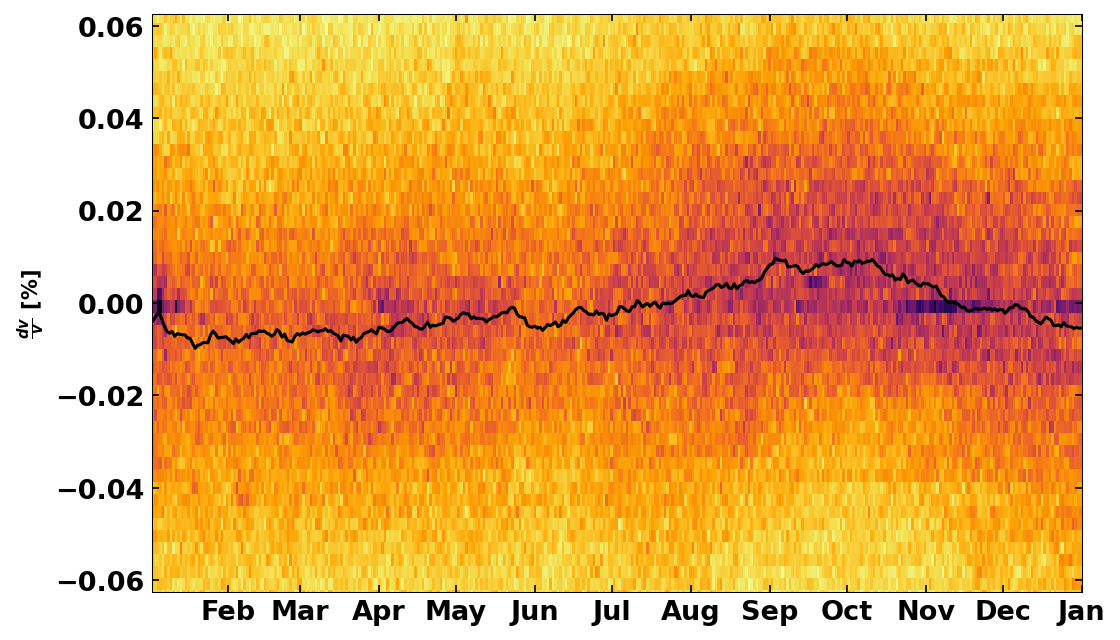

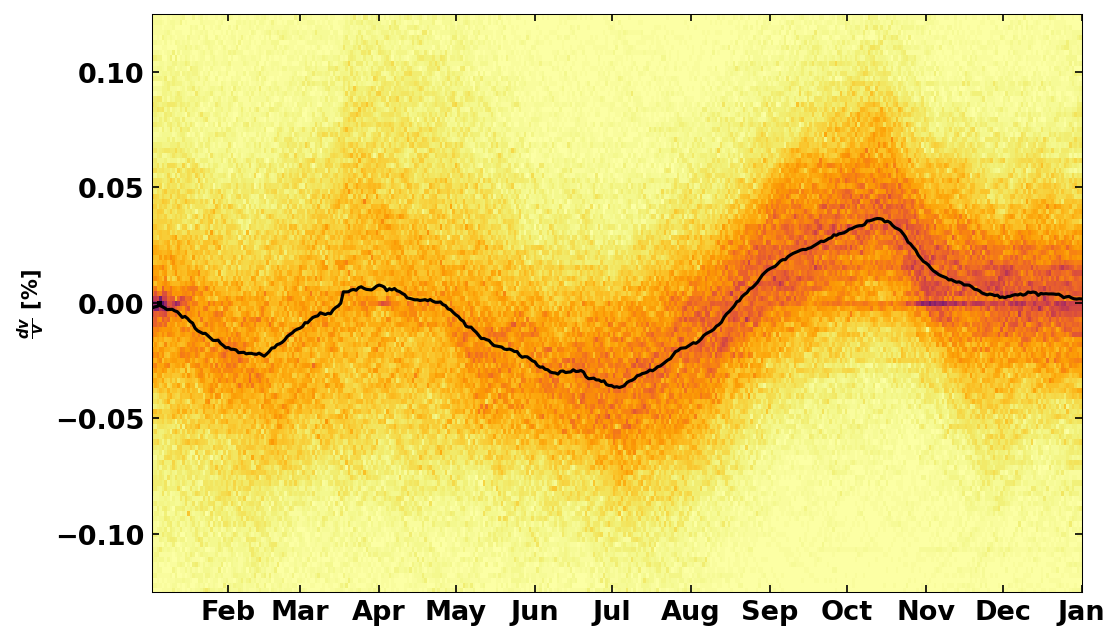

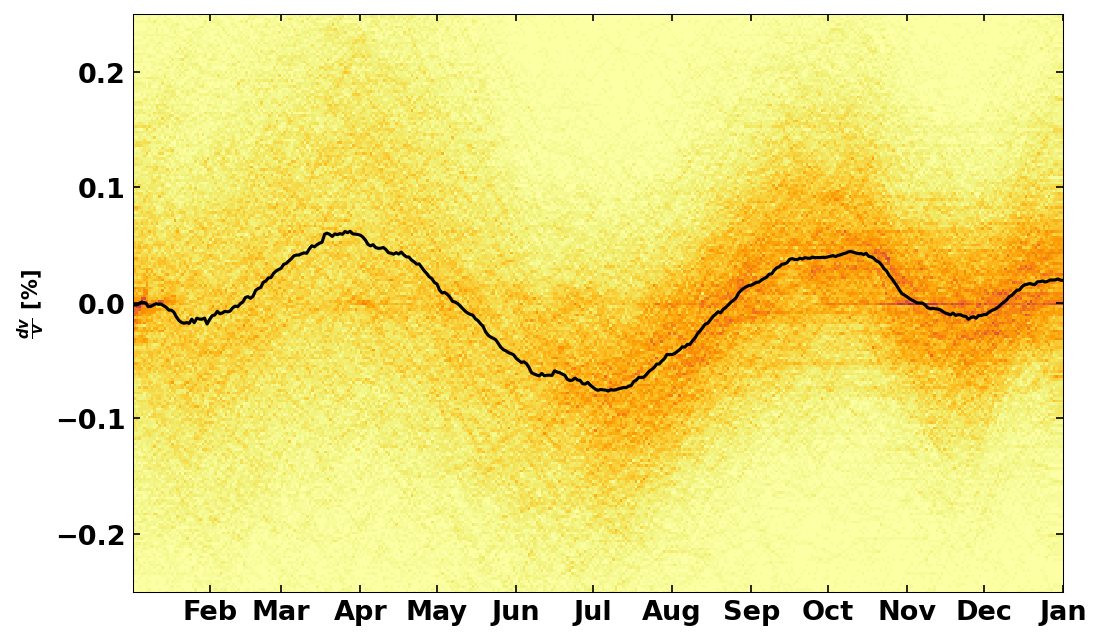

In [40]:
from matplotlib import dates as mdates
# reshape
freq = 1.0

x_axis = [UTCDateTime(2004, julday=i).datetime for i in np.arange(1, 366)]

for freq in [0.25, 0.5, 1.0]:
    plt.figure(figsize=(8, 5))
    x_hist = np.tile(np.arange(1, 366), dv_median_single[freq].shape[0])
    y_hist = np.reshape(dv_median_single[freq], (-1))
    nanii = np.isnan(y_hist)
    plt.hist2d(x_hist[~nanii], y_hist[~nanii], bins=(365, 2000), cmap='inferno_r');
    plt.plot(np.arange(1,366), np.nanmedian(dv_median_single[freq], axis=0), label='1.0 Hz', color='k')

    plt.ylim((-freq/4, freq/4))
    plt.ylabel(r'$\frac{dv}{v}$ [%]')
    locator = mdates.MonthLocator()  # every month
    # Specify the format - %b gives us Jan, Feb...
    fmt = mdates.DateFormatter('%b')

    X = plt.gca().xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)
    # remove minor x-ticks
    plt.minorticks_off()

### Do the same for GPS

/tmp/ipykernel_10611/681181683.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label='Elevation [m]')


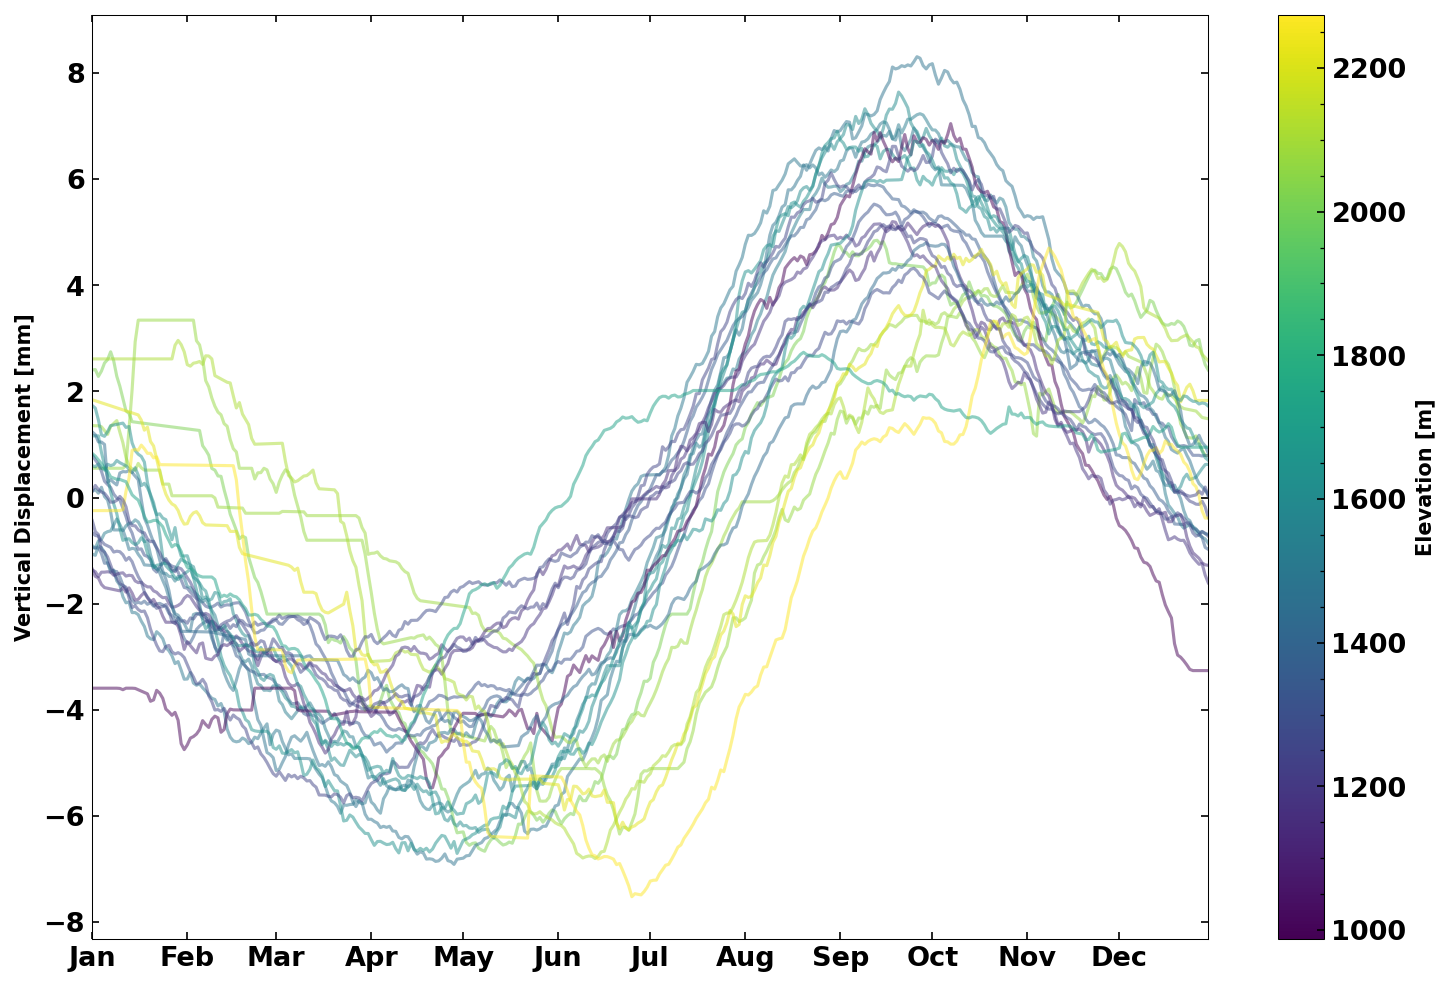

In [41]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import dates as mdates
from obspy import UTCDateTime

gps_medians = []
stations = []

# color code by elevation
# extract range of elevations
elevations = np.unique(np.array([df['elevation'][0] for df in positions.values()]))

# create a color map

cmap = cm.viridis
norm = colors.Normalize(vmin=np.min(elevations), vmax=np.max(elevations))
elevations = []

x_axis = [UTCDateTime(2004, julday=i).datetime for i in np.arange(1, 366)]

plt.figure(figsize=(12, 8))

for key, df in positions.items():
    doy = np.array([UTCDateTime(_date).julday for _date in df['datetime']])
    years = np.array([_date.year for _date in df['datetime']])
    years_unique = np.unique(years)
    x_data = []
    y_data = []

    for year in years_unique:
        x_data.append(doy[years==year])
        y_data.append(df['offset_hpf'][years==year])
    # intepolate all these curves for the same doys
    xq = np.arange(1, 366)
    yq = np.zeros((len(years_unique), len(xq)))
    for ii, (x_datum, y_datum) in enumerate(zip(x_data, y_data)):
        yq[ii] = \
            np.interp(xq, x_datum, y_datum)
    y_median = np.nanmedian(yq, axis=0)
    gps_medians.append(y_median)
    stations.append(key)
    elevations.append(df['elevation'][0])
    # plot
    plt.plot(
        x_axis, y_median*1e3, color=cmap(norm(df['elevation'][0])), label=key,
        alpha=0.5)
# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, label='Elevation [m]')

gps_medians = np.array(gps_medians)
# plt.plot(xq, gps_medians.T, alpha=.5, label=stations);
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1), ncol=2)
plt.ylabel('Vertical Displacement [mm]')
plt.xlim(x_axis[0], x_axis[-1])
# month locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')

X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
# remove minor x-ticks
plt.minorticks_off()

Text(0.5, 0, 'Elevation [m]')

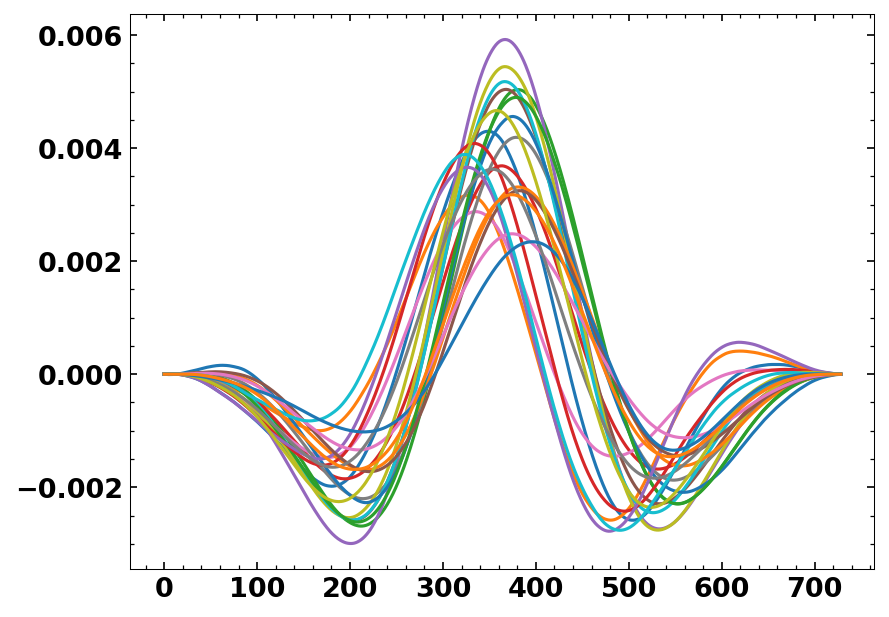

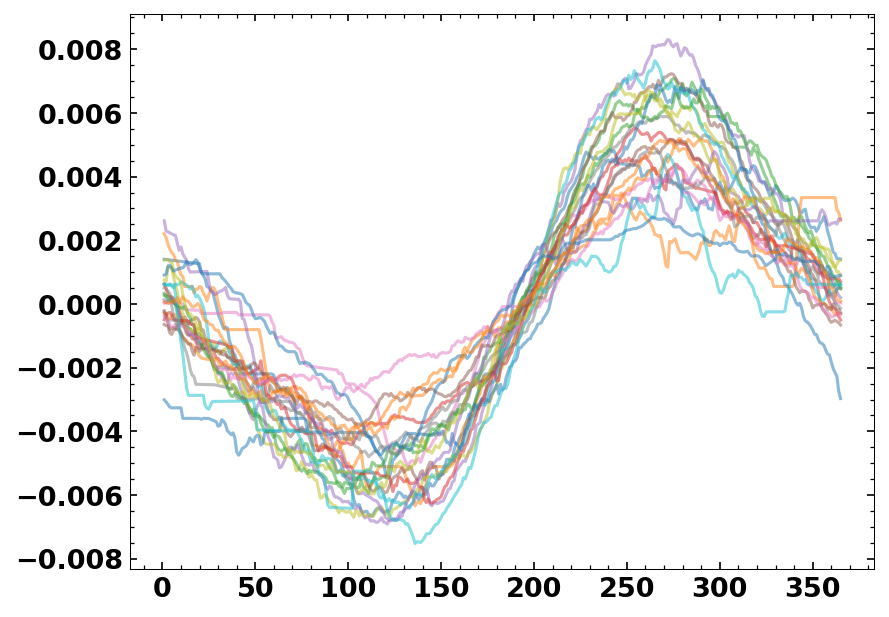

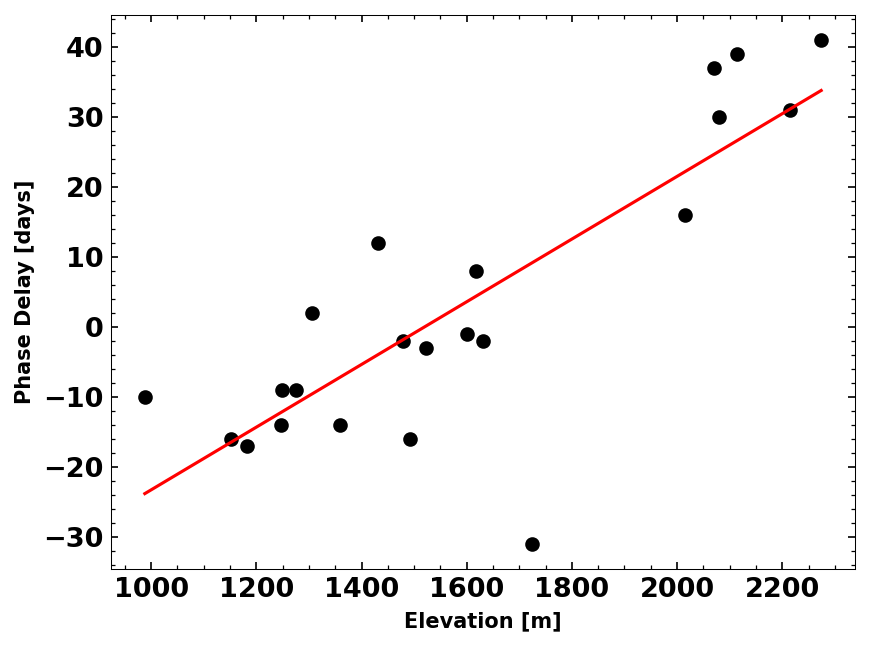

In [42]:
# find phase shifts between the different GPS stations
from scipy.signal import correlate
from scipy.optimize import minimize
from scipy.stats import linregress

# compute median of all medians
total_median = np.median(gps_medians, axis=0)
# find phase shifts between the different GPS stations
# compute cross-correlation between all stations
# and the total median
# for each station, find the phase shift that maximises the
# cross-correlation with the total median
phase_shifts = []
for median in gps_medians:
    # compute cross-correlation
    cc = correlate(total_median, median)
    # find maximum
    maxind = np.argmax(cc)
    phase_shifts.append(maxind-365)
    plt.plot(cc)

# roll the data by the phase shift
# so that all stations are aligned
# with the total median
gps_medians_shifted = np.zeros_like(gps_medians)
for ii, (median, shift) in enumerate(zip(gps_medians, phase_shifts)):
    gps_medians_shifted[ii] = np.roll(median, shift)

# plot the shifted data
plt.figure()
plt.plot(xq, gps_medians_shifted.T, alpha=.5, label=stations);

plt.figure()
phase_delay = -np.array(phase_shifts)
plt.scatter(elevations, phase_delay, c='k')
# plot linear regression
slope, intercept, r_value, p_value, std_err = linregress(elevations, phase_delay)
x = np.array([np.min(elevations), np.max(elevations)])
y = slope*x + intercept
plt.plot(x, y, 'r', label=f'slope={slope:.2f} days/m')
plt.ylabel('Phase Delay [days]')
plt.xlabel('Elevation [m]')

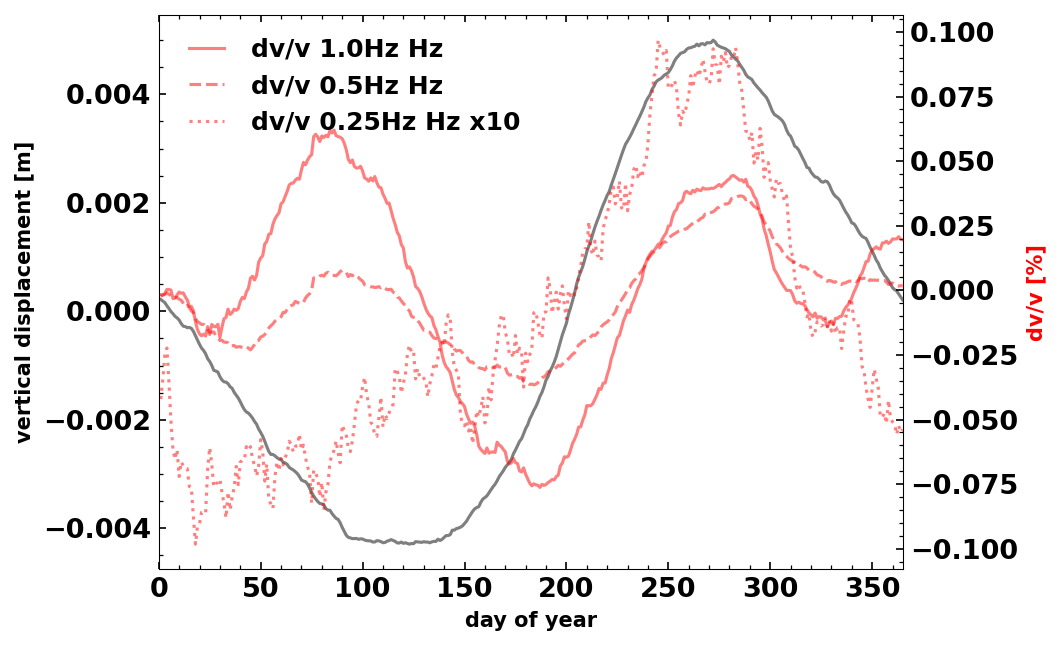

In [43]:
# plot gps median together with dv median
plt.plot(xq, np.mean(gps_medians, axis=0), alpha=.5, label='GPS', color='k');
plt.ylabel('vertical displacement [m]')
plt.xlabel('day of year')
plt.twinx()
# plt.plot(xq, np.mean(dv_medians/8, axis=0), alpha=.5, label='dv/v', color='r');
plt.plot(xq, np.nanmedian(dv_median_single[1.0], axis=0), alpha=.5, label=r'dv/v 1.0Hz Hz', color='r');
plt.plot(xq, np.nanmedian(dv_median_single[0.5], axis=0), alpha=.5, label=r'dv/v 0.5Hz Hz', color='r', linestyle='--');
plt.plot(xq, np.nanmedian(dv_median_single[0.25]*10, axis=0), alpha=.5, label=r'dv/v 0.25Hz Hz x10', color='r', linestyle=':');
plt.legend ()
plt.ylabel('dv/v [%]', color='r')
plt.xlim(0, 365)
plt.savefig('/home/pm/Documents_sync/PhD/StHelens/paper/figures/dv_median.pdf', facecolor='None')


## extract median water_influx


(17, 365)


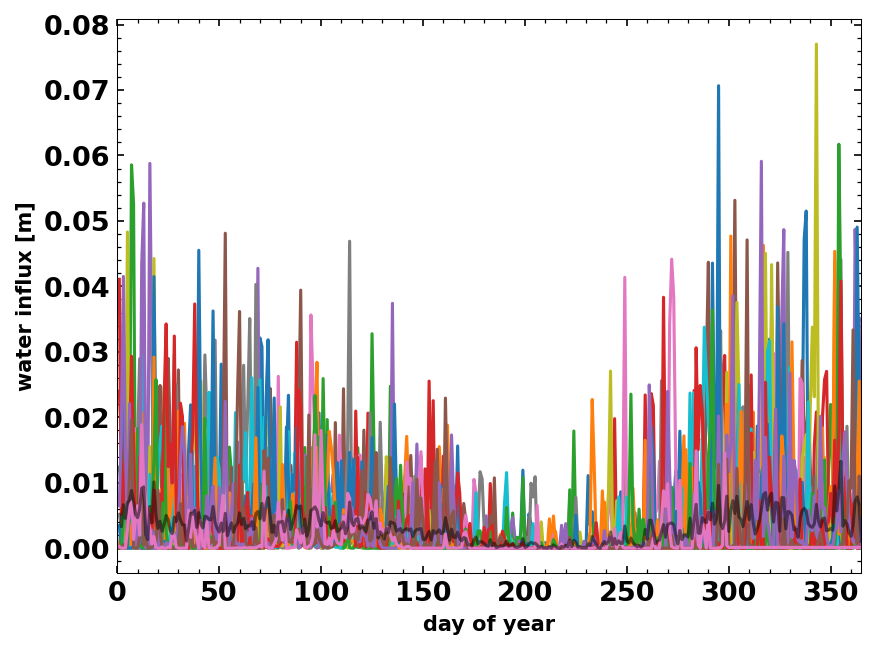

In [44]:
infile = '../climate data/era5_data.npz'

loaded = np.load(infile)

water_influx = loaded['water_influx']
# extract median over the whole area
water_influx = np.nanmedian(water_influx, axis=(1, 2))
years_unique = np.arange(1993, 2024)
t_weather = np.array(
        [datetime.datetime(int(years_unique[0]), 1, 1) + i*datetime.timedelta(days=1) for i in range(
            water_influx.shape[0])])
years = np.array([_date.year for _date in t_weather])
doy = np.array([UTCDateTime(_date).julday for _date in t_weather])

x_data = []
y_data = []

# disregard years for which we do not have dv/v data
years_unique = np.arange(2007, 2024)

for year in years_unique:
    x_data.append(doy[years==year])
    y_data.append(water_influx[years==year])
# intepolate all these curves for the same doys
xq = np.arange(1, 366)
yq = np.zeros((len(years_unique), len(xq)))
for ii, (x_datum, y_datum) in enumerate(zip(x_data, y_data)):
    yq[ii] = \
        np.interp(xq, x_datum, y_datum)
plt.plot(xq, np.array(yq.T))
plt.ylabel('water influx [m]')
plt.xlabel('day of year')
plt.xlim(0, 365)
# plot median
print(yq.shape)
plt.plot(xq, np.nanmean(yq, axis=0), alpha=.5, label='median', color='k');
mean_water_influx = np.nanmean(yq, axis=0)
# smooth this with a 30 day window
mean_water_influx = np.convolve(mean_water_influx, np.ones(30)/30, mode='same')

In [45]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

### Like this but spatial seperation

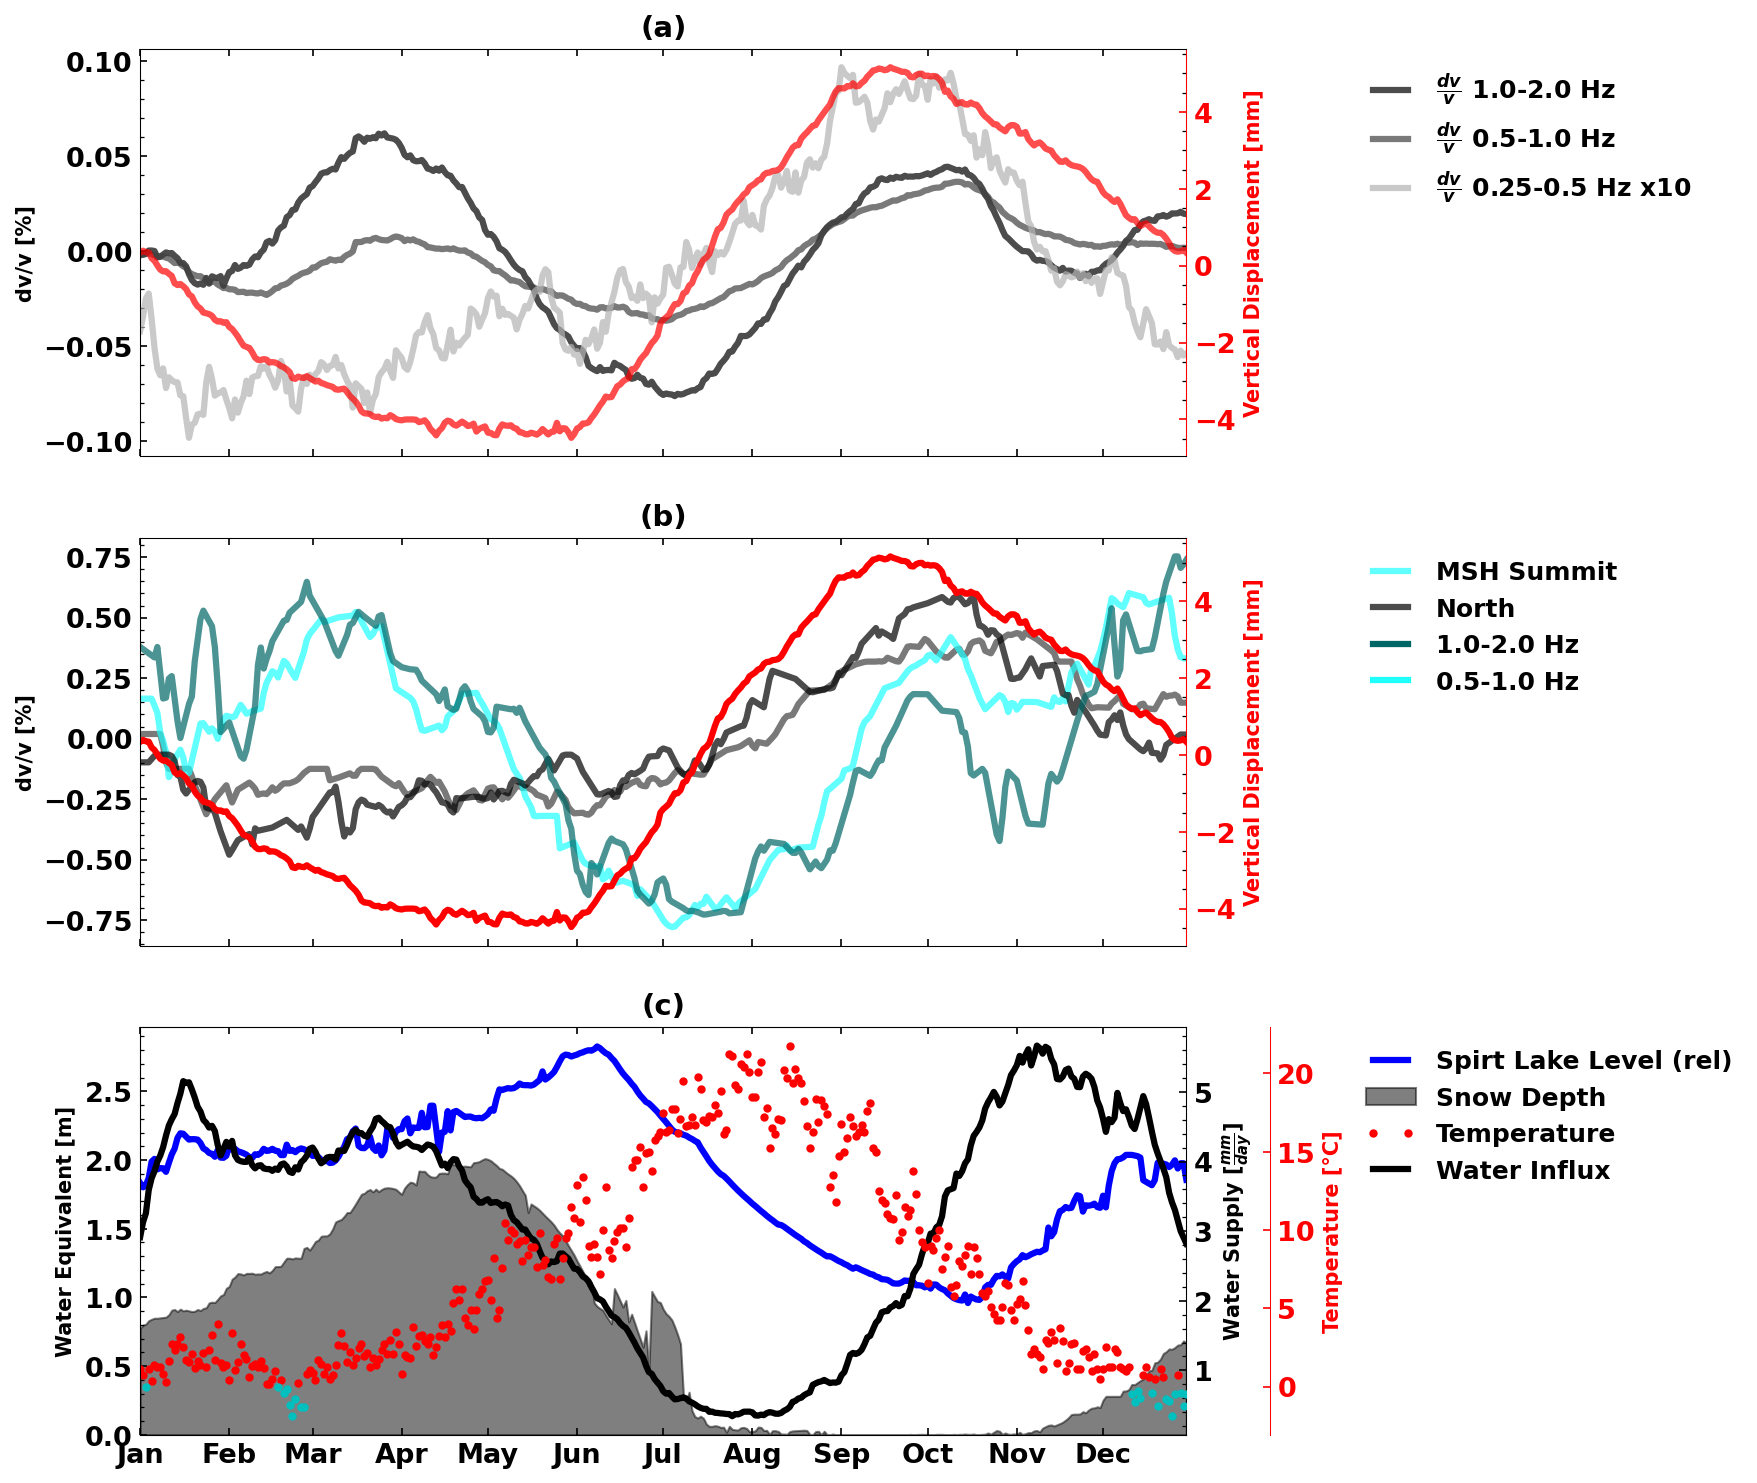

In [46]:
import matplotlib.dates as mdates


years = np.array([_date.year for _date in datetimes])
doy = np.array([UTCDateTime(_date).julday for _date in datetimes])
years_unique = np.unique(years)


x_date = [UTCDateTime(year=2004, julday=_doy).datetime for _doy in np.arange(1, 366)]

freq = 1.0


# increase linewidth of plot
plt.rcParams['lines.linewidth'] = 3

# for m in np.arange(dv_hpf[freq].shape[0]//3, 2*dv_hpf[freq].shape[0]//3, 1):

#     for n in np.arange(dv_hpf[freq].shape[1]//4, dv_hpf[freq].shape[1]//2, 1):

plt.subplots(3, 1, figsize=(9, 12), sharex=True)
# plot gps median together with dv median
plt.subplot(3, 1, 1)
# plt.plot(xq, np.mean(dv_medians/8, axis=0), alpha=.5, label='dv/v', color='r');
plt.plot(x_date, np.nanmedian(dv_median_single[1.0], axis=0), alpha=.7, label=r'$\frac{dv}{v}$ 1.0-2.0 Hz', color='k');
plt.plot(x_date, np.nanmedian(dv_median_single[0.5], axis=0), alpha=.7, label=r'$\frac{dv}{v}$ 0.5-1.0 Hz', color=lighten_color('k', 0.75));
plt.plot(x_date, np.nanmedian(dv_median_single[0.25]*10, axis=0), alpha=.7, label=r'$\frac{dv}{v}$ 0.25-0.5 Hz x10', color=lighten_color('k', 0.3));
plt.legend(loc='upper left', bbox_to_anchor=(1.15, 1))
plt.ylabel('dv/v [%]', color='k')
# plt.xlim(0, 365)
plt.twinx()
plt.plot(x_date, 1000*np.median(gps_medians, axis=0), alpha=.7, label='GPS', color='r');
plt.ylabel(r'Vertical Displacement [mm]', color='r')
plt.gca().spines['right'].set_color('red')
plt.gca().yaxis.label.set_color('r')
plt.gca().tick_params(axis='y', colors='r')
plt.title('(a)')

plt.xlabel('day of year')
# add horizontal gridlines
plt.grid(axis='x', which='both')

plt.subplot(3, 1, 2)

for freq in [0.25, 0.5, 1.0]:
    dv_medians = []
    m = dv_hpf[freq].shape[0]-4
    n = dv_hpf[freq].shape[1]//2
    x_data = []
    y_data = []

    for year in years_unique:
        # plt.plot(doy[years==year], dv_hpf[freq][m, n, years==year], label=year, alpha=.2, color='k')
        # collect data to compute median
        x_data.append(doy[years==year])
        # y_data.append(dv_hpf[freq][m, n, years==year])
        y_data.append(dv[freq][m, n, years==year])

    # intepolate all these curves for the same doys
    xq = np.arange(1, 366)
    yq = np.zeros((len(years_unique), len(xq)))
    for ii, (x_datum, y_datum) in enumerate(zip(x_data, y_data)):
        yq[ii] = \
            np.interp(xq, x_datum, y_datum)
        # demean
        yq[ii] -= np.nanmean(yq[ii])
    y_median = np.nanmedian(yq, axis=0)
    dv_medians.append(y_median)

    m, n = 15, 19
    x_data = []
    y_data = []

    for year in years_unique:
        # plt.plot(doy[years==year], dv_hpf[freq][m, n, years==year], label=year, alpha=.2, color='k')
        # collect data to compute median
        x_data.append(doy[years==year])
        # y_data.append(dv_hpf[freq][m, n, years==year])
        y_data.append(dv[freq][m, n, years==year])

    # intepolate all these curves for the same doys
    xq = np.arange(1, 366)
    yq = np.zeros((len(years_unique), len(xq)))
    for ii, (x_datum, y_datum) in enumerate(zip(x_data, y_data)):
        yq[ii] = \
            np.interp(xq, x_datum, y_datum)
        # demean
        yq[ii] -= np.nanmean(yq[ii])
    y_median = np.nanmedian(yq, axis=0)
    dv_medians.append(y_median)
    dv_medians = np.array(dv_medians)
    if freq == 1.0:
        plt.plot(x_date, dv_medians[0], alpha=.7, color='k', label='North');
        plt.plot(x_date, dv_medians[1], alpha=.7, color=lighten_color('cyan', 1.6));
        # plt.plot(xq, dv_medians[2], alpha=.7, linestyle='-', color='C3', label='Southeast');
    elif freq == 0.5:
        plt.plot(x_date, dv_medians[0], alpha=.7, color=lighten_color('k', 0.75));
        plt.plot(x_date, dv_medians[1], alpha=.7, color=lighten_color('c', .7), label='MSH Summit');
        # plt.plot(xq, dv_medians[2], alpha=.7, linestyle='--', color='C3', label='Southeast');
    # else:
    #     plt.plot(x_date, dv_medians[0]*10, alpha=.7, color=lighten_color('k', .3), linewidth=4);
    #     plt.plot(x_date, dv_medians[1]*10, alpha=.7, color=lighten_color('c', 0.3), linewidth=4);
        # plt.plot(xq, dv_medians[2], alpha=.7, linestyle=':', color='C3', label='Southeast');
plt.plot(np.nan, np.nan, label='1.0-2.0 Hz', color=lighten_color('cyan', 1.6))
plt.plot(np.nan, np.nan, label='0.5-1.0 Hz', color=lighten_color('c', .7))
# plt.plot(np.nan, np.nan, label='0.25-0.5 Hz x10', color=lighten_color('cyan', .3))
plt.legend(loc='upper left', bbox_to_anchor=(1.15, 1))
plt.ylabel('dv/v [%]')
plt.twinx()
plt.ylabel('Vertical Displacement [mm]', color='r')
# make second y-axis red
plt.gca().spines['right'].set_color('red')
plt.gca().yaxis.label.set_color('r')
plt.gca().tick_params(axis='y', colors='r')

plt.plot(x_date, np.nanmedian(gps_medians, axis=0)*1e3, alpha=1, label='GPS', color='r');
plt.title('(b)')

# also add weather data from npz
weather = np.load('../climate data/annual_waterlevel.npz')
annual_lakelevel = weather['annual_lakelevel']
annual_snowdepth = weather['annual_snowdepth']
annual_borehole = weather['annual_borehole']
annual_T = weather['annual_T']
plt.subplot(3, 1, 3)
plt.plot(x_date, np.nanmedian(annual_lakelevel, axis=0), label='Spirt Lake Level (rel)', color='b')
# plt.plot(np.arange(1, 366), , label='Snow depth', color='k')
plt.fill_between(x_date, 0, np.nanmedian(annual_snowdepth, axis=0), color='k', alpha=0.5, label='Snow Depth')
# add nan plots for legend
plt.plot(np.nan, np.nan, 'ro', markersize=3, label='Temperature')
plt.plot(np.nan, np.nan, 'k', label='Water Influx')
plt.ylabel('Water Equivalent [m]')
plt.legend(loc='upper left', bbox_to_anchor=(1.15, 1))
# plt.xlabel('Day of Year')
# plt.xlim(1, 365)
plt.xlim(x_date[0], x_date[-1])
plt.ylim(0, None)
plt.title('(c)')

# add mean water influx
ax = plt.gca()
ax_influx = ax.twinx()
plt.plot(x_date, mean_water_influx*1000, label='Mean Water Influx', color='k')
plt.ylabel(r'Water Supply [$\frac{mm}{day}$]')
# add temperature
ax.twinx()
median_T = np.nanmedian(annual_T, axis=0)
plt.plot(
    np.array(x_date)[median_T>0], median_T[median_T>0], 'ro', label='Temperature', markersize=3)
plt.plot(
    np.array(x_date)[median_T<=0], median_T[median_T<=0], 'co', label='Temperature', markersize=3)

# iceblue dashed line at freezing
# plt.axhline(0, color='cyan', linestyle='--', alpha=0.5, linewidth=1, zorder=0)
plt.ylabel('Temperature [°C]', color='r')
plt.gca().spines['right'].set_color('r')
plt.gca().yaxis.label.set_color('r')
plt.gca().tick_params(axis='y', colors='r')
plt.gca().spines.right.set_position(("axes", 1.08))

# only show months on x-axis
# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')

X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
# remove minor x-ticks
plt.minorticks_off()


plt.savefig(f'/home/pm/Documents_sync/PhD/StHelens/paper/figures/median_spatial_2regions_allfreqs.pdf', dpi=300, bbox_inches='tight', facecolor='None')